https://github.com/busesese/DeepFM_Keras/blob/master/DeepFM/deepfm.py

In [106]:
import numpy as np 
from keras.layers import Input, Dense, Embedding, Add, Concatenate, RepeatVector,Multiply,Subtract,Lambda,Dropout,Reshape,Flatten
from keras.models import Model
from keras.utils import plot_model
from mylayers import MySumLayer
from keras.optimizers import Adam
# import config
from keras.metrics import binary_accuracy
# from metrics import auc
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder 
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

## Data Loading

In [107]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","YN_final_df2.csv"))
df.head()
# df = pd.read_csv(os.path.join("..","..","data","YN_final_df.csv"))
# df.head()

,rating,locationId,photonum,createdDate,is_fch,is_local,place.name,userID,average_photonum,average_rating,user_mean_rating,user_reviewcount,lat,lng,land.addr,category,rated_count,category_l
0,4.5,1150710065,0,2020-05-21 20:42:00,1,1,스타벅스 보라매공원R점,432293,0.164557,4.506329,4.5,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
1,5.0,1150710065,0,2019-06-28 01:11:03,1,1,스타벅스 보라매공원R점,135109,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
2,5.0,1150710065,0,2020-03-12 00:22:00,1,1,스타벅스 보라매공원R점,269138,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
3,5.0,1150710065,0,2020-02-16 17:06:00,1,1,스타벅스 보라매공원R점,246123,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
4,5.0,1150710065,0,2019-03-11 00:08:48,1,1,스타벅스 보라매공원R점,119248,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1


### 로컬 / 글로벌 데이터 분리

In [108]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['is_local']==1]
global_df = df.loc[df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (381125, 18) global_df shape : (98566, 18)


In [109]:
# 로컬, 글로벌 공통 location id 뽑기
local_id = local_df['locationId'].unique().tolist()
global_id = global_df['locationId'].unique().tolist()

common_ids = []
for i in local_id:
    if i in global_id:
        common_ids.append(i)

common_acm = df.loc[df['locationId'].isin(common_ids)]
common_acm = common_acm.loc[common_acm['category']=='ACM']
common_acm_ids = common_acm['locationId'].unique().tolist()
# global, local 모두 담은 acm location ids
print(len(common_acm_ids)) 

245


### 장소 전처리

## 1. local

In [110]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]

# 의미없는 추천 식당 제거 
local_df = local_df[~local_df['place.name'].str.contains('써브웨이|던킨도너츠|노브랜드버거|바르다김선생|폴바셋|안동찜닭|속초코다리냉면|할매순대국&양선지해장국|노브랜드버거 남부터미널점|바르다김선생|유가네|24시 중식당 취빈|매머드커피|압구정봉구비어|카페베네|쥬씨|피자스쿨|매머드익스프레스|김밥천국|한국맥도날드|메머드커피|신전떡볶이|어사또|공차|북촌손만두|오징어세상|사월에보리밥|땡스브레드엔커피|피자몰|나주소나주곰탕| 새마을식당|싸다김밥| 교동짬뽕| 토마토김밥| 화화쿵주마라탕| 샐러데이즈| 더차이|뚜레쥬르|스쿨푸드|자연별곡|죠스떡볶이|국대떡볶이| 도쿄스테이크|이디야커피| 코스트코코리아양재점푸드코트| 불고기브라더스|알라딘중고서점카페|배스킨라빈스|할리스커피| 와플대학| 파리바게뜨공덕역사| 파리바게뜨|아웃백|설빙| 봉추찜닭| 하겐다즈|아라마크연세의료원종합관|미아리우동집| 서울대학생회관식당|세계과자할인마트| 이삭토스트| 굽네치킨| 깐부치킨| 굽네치킨| 빈스앤베리즈| 롯데리아|던킨 도너츠|피자헛|미쓰족발|덕수궁')]
print('의미없을만한 식당 제거 후 local데이터 크기:',local_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (126061, 18)


In [111]:
# 데이터 저장
local_df.to_csv(os.path.join("..","realtime_model",'local_df(deepFM).csv'), index=False)

In [112]:
RANDOMSTATE = 2018

COLS=['locationId',  'createdDate', 'photonum', 'rated_count', 'average_photonum',
        'average_rating', 'user_mean_rating', 'user_reviewcount','userID' ] 

In [113]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 4675,
 'createdDate': 78717,
 'photonum': 32,
 'rated_count': 232,
 'average_photonum': 1080,
 'average_rating': 952,
 'user_mean_rating': 10,
 'user_reviewcount': 6,
 'userID': 124743}

In [114]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [115]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.2)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
prediction = Dense(1,activation='sigmoid')(y)

In [116]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

Train on 125430 samples, validate on 631 samples
Epoch 1/100
125430/125430 [==============================] - 2s 18us/step - loss: 13.5700 - auc_4: 0.0000e+00 - val_loss: 17.0222 - val_auc_4: 0.0000e+00

Epoch 00001: val_loss improved from inf to 17.02219, saving model to ../../data/model_weights/local_01-17.0222.hdf5

Epoch 00001: val_loss improved from inf to 17.02219, saving model to ../../data/model_weights/local_01.json
Epoch 2/100
125430/125430 [==============================] - 1s 6us/step - loss: 13.1554 - auc_4: 0.0000e+00 - val_loss: 16.0523 - val_auc_4: 0.0000e+00

Epoch 00002: val_loss improved from 17.02219 to 16.05230, saving model to ../../data/model_weights/local_02-16.0523.hdf5

Epoch 00002: val_loss improved from 17.02219 to 16.05230, saving model to ../../data/model_weights/local_02.json
Epoch 3/100
125430/125430 [==============================] - 1s 6us/step - loss: 13.1094 - auc_4: 0.0000e+00 - val_loss: 16.0523 - val_auc_4: 0.0000e+00

Epoch 00003: val_loss did no

125430/125430 [==============================] - 1s 8us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00031: val_loss did not improve from 16.03803

Epoch 00031: val_loss did not improve from 16.03803
Epoch 32/100
125430/125430 [==============================] - 1s 8us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00032: val_loss did not improve from 16.03803

Epoch 00032: val_loss did not improve from 16.03803
Epoch 33/100
125430/125430 [==============================] - 1s 6us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00033: val_loss did not improve from 16.03803

Epoch 00033: val_loss did not improve from 16.03803
Epoch 34/100
125430/125430 [==============================] - 1s 6us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00034: val_loss did not improve from 16.03803

Epoch 00034: val_loss did


Epoch 00062: val_loss did not improve from 16.03803

Epoch 00062: val_loss did not improve from 16.03803
Epoch 63/100
125430/125430 [==============================] - 1s 5us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00063: val_loss did not improve from 16.03803

Epoch 00063: val_loss did not improve from 16.03803
Epoch 64/100
125430/125430 [==============================] - 1s 5us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00064: val_loss did not improve from 16.03803

Epoch 00064: val_loss did not improve from 16.03803
Epoch 65/100
125430/125430 [==============================] - 1s 5us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00065: val_loss did not improve from 16.03803

Epoch 00065: val_loss did not improve from 16.03803
Epoch 66/100
125430/125430 [==============================] - 1s 4us/step - loss: 13.1092 - auc_4: 0.0000e+00 - va


Epoch 00094: val_loss did not improve from 16.03803

Epoch 00094: val_loss did not improve from 16.03803
Epoch 95/100
125430/125430 [==============================] - 1s 4us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00095: val_loss did not improve from 16.03803

Epoch 00095: val_loss did not improve from 16.03803
Epoch 96/100
125430/125430 [==============================] - 1s 5us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00096: val_loss did not improve from 16.03803

Epoch 00096: val_loss did not improve from 16.03803
Epoch 97/100
125430/125430 [==============================] - 1s 4us/step - loss: 13.1092 - auc_4: 0.0000e+00 - val_loss: 16.0380 - val_auc_4: 0.0000e+00

Epoch 00097: val_loss did not improve from 16.03803

Epoch 00097: val_loss did not improve from 16.03803
Epoch 98/100
125430/125430 [==============================] - 1s 4us/step - loss: 13.1092 - auc_4: 0.0000e+00 - va

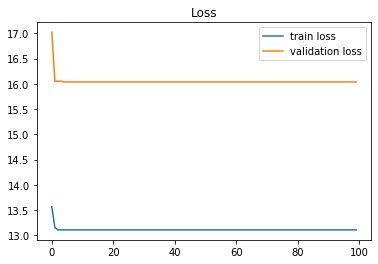

In [117]:
lr = 1e-1
epochs = 100
batch_size = 200000

model = Model(inputs=input_cols, outputs=prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], local_df['rating'], 
                        batch_size=batch_size, epochs=epochs, validation_split=0.005,
                        callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [118]:
# # 모델 불러오기 
# from keras.models import model_from_json 

# json_file = open(os.path.join(model_save_path ,"local_01.json"), "r",encoding="utf8", errors='ignore') 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json)# ,custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join(model_save_path,"local_01-12.3368.hdf5"))
                               
# print("Loaded model from disk")

# 유사도 아이템

In [119]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [120]:
vec = latent_to_vec('FM_locationId', model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [121]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_local_vec.csv'))

In [122]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

데이터 업뎃 후

In [123]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 가쯔레쯔
  주소 서울특별시 양천구 목동 917 목동파라곤
top 2 굿모닝
  주소 서울특별시 종로구 인사동 255-5
top 3 프로스트
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 4 소풍가는날
  주소 서울특별시 관악구 봉천동 1657-21
top 5 베르비에
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 6 산들해 목동점
  주소 서울특별시 양천구 신정동 321-6 센트럴프라자
top 7 댓짱돈까스
  주소 서울특별시 양천구 목동 923-6 예술인회관
top 8 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 9 홍대김밥 신수점
  주소 서울특별시 마포구 현석동 108-1
top 10 목동포차 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 진미생태
  주소 서울특별시 마포구 용강동 508 e편한세상 마포3차
top 2 우동가조쿠 성수점
  주소 서울특별시 성동구 성수동2가 301-53
top 3 양천뼈다귀본점
  주소 서울특별시 양천구 목동 934 목동금호1차아파트
top 4 한나식빵 송파점
  주소 서울특별시 송파구 방이동 224-9
top 5 그릴드300
  주소 서울특별시 마포구 동교동 150-3
top 6 비블레스
  주소 서울특별시 강남구 삼성동 155-3
top 7 칼리가리브루잉탭룸 익선점
  주소 서울특별시 종로구 익선동 163
top 8 삼육가 사당역직영점
  주소 서울특별시 서초구 방배동 450-16 동화빌딩
top 9 효제눅
  주소 서울특별시 종로구 효제동 61-1
top 10 포썸
  주소 서울특별시 성북구 동선동4가 111-1 골든타워
None



------------------------------

In [124]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 펠롱
  주소 서울특별시 중구 신당동 377-155
top 2 바삭마차 응암점
  주소 서울특별시 은평구 응암동 111-48
top 3 즉석 바지락손칼국수
  주소 서울특별시 동작구 대방동 335-15
top 4 아베크엘카페
  주소 서울특별시 용산구 후암동 41-1 몬테피오레
top 5 도쿄이찌바 롯데마트중계점
  주소 서울특별시 노원구 중계동 361 롯데마트
top 6 명인등심방배점
  주소 서울특별시 서초구 방배동 818-11
top 7 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 8 010수산
  주소 서울특별시 강서구 등촌동 671-3 주양빌딩
top 9 이화원
  주소 서울특별시 서대문구 연희동 189-8
top 10 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 올리브케이 
  주소 서울특별시 서초구 반포동 723-11 왕건빌딩
top 3 주시브로스 그랑서울점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 4 그레인
  주소 서울특별시 마포구 연남동 385-6
top 5 신락원
  주소 서울특별시 동대문구 전농동 60-32
top 6 배꼽집
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 7 도토리브라더스
  주소 서울특별시 종로구 신문로2가 1-248
top 8 스시바 신세계백화점 본점
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
top 9 대천분식
  주소 서울특별시 동작구 노량진동 330 삼익주상복합아파트
top 10 아저씨강정
  주소 서울특별시 관악구 신림동 1587-6
None



---------------------

In [125]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 마므레 크로와상
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 2 원스타 올드패션드 햄버거
  주소 서울특별시 강남구 도곡동 424-11
top 3 동의보쌈왕족발
  주소 서울특별시 양천구 목동 610-16
top 4 연교
  주소 서울특별시 마포구 연남동 383-95
top 5 이품분식
  주소 서울특별시 마포구 연남동 228-8
top 6 칼리가리브루잉탭룸 익선점
  주소 서울특별시 종로구 익선동 163
top 7 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 8 창덕궁
  주소 서울특별시 종로구 묘동 160-1
top 9 집밥
  주소 서울특별시 양천구 신월동 971-2
top 10 등촌정육식당
  주소 서울특별시 강서구 등촌1동 635-8
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 2 선미옥바지락칼국수얼큰수제비
  주소 서울특별시 마포구 도화동 203-2
top 3 슬로우레시피
  주소 서울특별시 종로구 통의동 91-47
top 4 오리마당
  주소 서울특별시 중구 태평로2가 43 한화금융센터 태평로
top 5 원조보리밥
  주소 서울특별시 용산구 이태원동 34-103
top 6 TIS COFFEE
  주소 서울특별시 마포구 동교동 147-2 동교동빌딩
top 7 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 8 명일원조닭발
  주소 서울특별시 강동구 명일동 325-16
top 9 연남방앗간
  주소 서울특별시 마포구 연남동 257-22
top 10 야마야
  주소 서울특별시 강남구 역삼동 648-9
None



--------------------------------------------------
input hot

In [126]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 스타즈호텔 명동1호점
----------
top 1 모나드 커피로스터스
  주소 서울특별시 금천구 시흥동 911-6
top 2 TIS COFFEE
  주소 서울특별시 마포구 동교동 147-2 동교동빌딩
top 3 광주똑순이아구찜
  주소 서울특별시 강서구 마곡동 722-3 정호빌딩
top 4 아티제사당파스텔시티점
  주소 서울특별시 서초구 방배동 444-3 SK리더스뷰
top 5 개화기요정
  주소 서울특별시 마포구 서교동 401-5
top 6 비사벌전주콩나물국밥
  주소 서울특별시 송파구 잠실본동 250-13 동서빌딩
top 7 고창집
  주소 서울특별시 동대문구 청량리동 50-22
top 8 이춘복참치 노원점
  주소 서울특별시 노원구 상계동 324-5
top 9 니나노김밥
  주소 서울특별시 종로구 종로6가 173
top 10 포비 광화문
  주소 서울특별시 종로구 청진동 268-2
None



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 강릉육쪽마늘빵 신세계 타임스퀘어
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 2 팡파미유 롯데백화점 노원점
  주소 서울특별시 노원구 상계동 713 롯데백화점
top 3 짬뽕주의
  주소 서울특별시 서대문구 충정로2가 29
top 4 베르비에
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 5 리얼파스타 성신여대점
  주소 서울특별시 성북구 동선동1가 3-4
top 6 주은감자탕
  주소 서울특별시 송파구 삼전동 132-14
top 7 김여사네 국수
  주소 서울특별시 강동구 성내동 19-9
top 8 이팡 홍대점
  주소 서울특별시 마포구 서교동 330-21
top 9 버섯집
  주소 서울특별시 성동구 성수동1가 668-34
top 10 이디야 가든파이브점
  주소 서울특별시 송파구 문정동 628 가든파이브툴
None



------------

In [127]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 서울웨스틴조선호텔 아리아
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 2 STEM 상암점
  주소 서울특별시 마포구 성산동 420 월드컵경기장역
top 3 정성식당
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 4 밥향기
  주소 서울특별시 송파구 가락동 77-4 송파KCC웰츠타워
top 5 논현손칼국수
  주소 서울특별시 강남구 논현동 193-38
top 6 할머니냉면
  주소 서울특별시 동대문구 제기동 470
top 7 그레이스케일커피
  주소 서울특별시 강남구 역삼동 618-8
top 8 카페 노티드 안국점
  주소 서울특별시 종로구 재동 86
top 9 커피볶는이야기두번째공간
  주소 서울특별시 성북구 동소문동1가 32-2
top 10 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 오장도너츠맛집
  주소 서울특별시 중구 오장동 69-3 수협
top 2 보칼리노
  주소 error
top 3 우리집만두
  주소 서울특별시 강남구 대치동 897
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 6 G카페
  주소 서울특별시 강서구 마곡동 770 엘지사이언스파크
top 7 효모
  주소 서울특별시 송파구 잠실동 206-4
top 8 독도수산
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
top 9 쥬뗑뷔뜨
  주소 서울특별시 송파구 석촌동 283-10
top 10 즉석우동짜장
  주소 서울특별시 영등포구 신길동 4216
None



--------------------------------------------------
input h

In [128]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 노블베이커리
  주소 서울특별시 서대문구 남가좌동 338-1
top 2 Deweet
  주소 서울특별시 마포구 연남동 260-14
top 3 The View
  주소 error
top 4 유라쿠
  주소 서울특별시 은평구 대조동 198-27
top 5 로우키
  주소 서울특별시 성동구 성수동2가 302-16
top 6 롤앤밥스
  주소 서울특별시 관악구 신림동 1515-11
top 7 건대고기 본점
  주소 서울특별시 광진구 자양동 5-4
top 8 서울편백찜 망원점
  주소 서울특별시 마포구 서교동 442-4
top 9 커피템플 2호점
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 10 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 덕수정
  주소 서울특별시 중구 정동 11-5
top 2 고씨네
  주소 서울특별시 성북구 정릉동 227-67
top 3 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 4 돈수작
  주소 서울특별시 광진구 능동 220-12
top 5 소르빌로1991
  주소 서울특별시 성북구 동선동1가 92-3
top 6 바삭마차 응암점
  주소 서울특별시 은평구 응암동 111-48
top 7 김씨네
  주소 서울특별시 강남구 신사동 627-6
top 8 브레댄코
  주소 서울특별시 성동구 성수동2가 308-4 서울숲코오롱디지털타워
top 9 미니네
  주소 서울특별시 중구 신당동 292-141
top 10 찬스브로스
  주소 서울특별시 용산구 이태원동 561
None



--------------------------------------------------
input hotel: 머큐어 서울 앰

In [129]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 바다회사랑
  주소 서울특별시 마포구 연남동 566-8
top 3 서울카츠
  주소 서울특별시 중구 필동2가 15-14
top 4 고기꾼 김춘배 종로점
  주소 서울특별시 종로구 관철동 12-23
top 5 Chai797 청계천점(미래에셋센터원빌딩)
  주소 서울특별시 중구 수하동 67 미래에셋 센터원(Mirae Asset CENTER1)
top 6 드렁큰콰이즈
  주소 서울특별시 중구 충무로2가 53-9
top 7 마부자생삼겹살
  주소 서울특별시 강서구 마곡동 760 마곡나루역보타닉푸르지오시티
top 8 은사떡볶이
  주소 서울특별시 성동구 성수동1가 13-413
top 9 모랑
  주소 서울특별시 종로구 신문로1가 163 광화문오피시아빌딩
top 10 다가이순대국 상암점
  주소 서울특별시 마포구 상암동 36-6
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 허니버터아몬드앤프렌즈
  주소 서울특별시 중구 충무로2가 65-9 하이헤리엇
top 3 마크레인커피
  주소 서울특별시 강남구 신사동 657-24
top 4 HONESTCOFFEE
  주소 서울특별시 강남구 역삼동 700-20
top 5 스테이터 강남역점
  주소 서울특별시 강남구 역삼동 812
top 6 오모가리
  주소 서울특별시 강북구 미아동 160-46
top 7 짬뽕주의
  주소 서울특별시 서대문구 충정로2가 29
top 8 독수리다방
  주소 서울특별시 서대문구 창천동 31-4 독수리빌딩
top 9 최원석의돼지한판&서해쭈꾸미 건대2호점
  주소 서울특별시 광진구 화양동 5-42
top 10 문배동 육

In [130]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 카페C
  주소 서울특별시 용산구 이촌동 301-54 한강교회
top 2 고려보쌈
  주소 서울특별시 중구 무교동 25-1 원창빌딩
top 3 카페아토
  주소 서울특별시 관악구 신림동 1639-59
top 4 꽈대표
  주소 서울특별시 마포구 망원동 479-91
top 5 빵이가
  주소 서울특별시 노원구 상계동 1132-35
top 6 강남불백 1호점
  주소 서울특별시 강남구 역삼동 827-23
top 7 덕수정
  주소 서울특별시 중구 정동 11-5
top 8 서울안심축산 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 9 루스티크
  주소 서울특별시 서초구 서초동 1523-7 산해빌딩
top 10 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 도마
  주소 서울특별시 종로구 관훈동 15-1
top 3 고향집
  주소 서울특별시 강남구 논현동 115-5
top 4 청국장과보리밥 청담점
  주소 서울특별시 강남구 청담동 72-1
top 5 동대문닭한마리칼국수
  주소 서울특별시 강남구 논현동 114-27
top 6 라운즈맨커피
  주소 서울특별시 성북구 안암동5가 103-93
top 7 문배동 육칼
  주소 서울특별시 강남구 삼성동 156-6
top 8 노홍철천재
  주소 서울특별시 용산구 후암동 123-11
top 9 동경우동
  주소 서울특별시 중구 초동 17-1
top 10 가장맛있는족발 종로관철점
  주소 서울특별시 종로구 관철동 19-19
None



--------------------------------------------------
input hotel: 호텔

In [131]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 우리설렁탕
  주소 서울특별시 관악구 신림동 107-106
top 2 최원석의돼지한판&서해쭈꾸미 건대2호점
  주소 서울특별시 광진구 화양동 5-42
top 3 모이세해장국
  주소 서울특별시 은평구 역촌동 22-39 세신빌딩
top 4 캘리포니아피자키친 용산아이파크몰점
  주소 서울특별시 용산구 한강로3가 40-999 용산역
top 5 교촌치킨
  주소 서울특별시 성동구 성수동2가 331-8 광성유치원
top 6 데이앤데이
  주소 서울특별시 성동구 성수동2가 333-16 이마트 성수점
top 7 버섯잔치집
  주소 서울특별시 강동구 성내동 549-4 성원빌딩
top 8 썰스데이파티
  주소 서울특별시 용산구 이태원동 124-6
top 9 난랑
  주소 서울특별시 송파구 방이동 36-7 혜성빌딩
top 10 맘모스커피
  주소 서울특별시 마포구 서교동 327-15
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 서진식당
  주소 서울특별시 강남구 역삼동 824-25 대우디오빌플러스
top 2 미각아구동태해물찜 탕
  주소 서울특별시 성북구 정릉4동 401-2 시온쇼핑
top 3 산들
  주소 서울특별시 광진구 군자동 98 세종대학교
top 4 뿌자
  주소 서울특별시 종로구 창신동 207
top 5 레오니다스초콜릿카페
  주소 서울특별시 중구 명동2가 2-1 재원빌딩
top 6 기꾸스시
  주소 서울특별시 서대문구 창천동 62-15
top 7 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 8 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 9 양키통닭 & Second Floor
  주소 서울특별시 영등포구 문래동2가 49-1
top 10 포비 베이직
  주소 서울특별시 마포구 합정동 426-18
None



----

In [132]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 정성식당
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 2 이춘복참치 발산역점
  주소 서울특별시 강서구 등촌동 673-5 화인빌딩
top 3 그레이스케일커피
  주소 서울특별시 강남구 역삼동 618-8
top 4 할머니포장마차멸치국수
  주소 서울특별시 송파구 방이동 49-5 올림픽파크존
top 5 잘빠진메밀 서촌점
  주소 서울특별시 종로구 통인동 118-3
top 6 보라매 호프치킨
  주소 서울특별시 영등포구 신길동 4387
top 7 몬스터플레이스
  주소 서울특별시 용산구 청파동3가 114-3
top 8 이서방네분식
  주소 서울특별시 마포구 공덕동 462 마포공덕파크팰리스 Ⅱ
top 9 명인등심 삼성직영점
  주소 서울특별시 강남구 삼성동 148-15
top 10 태국식당356
  주소 서울특별시 서초구 양재동 10-52
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 메이비카페
  주소 서울특별시 구로구 구로동 1124-49
top 2 카우떡볶이
  주소 서울특별시 서대문구 대현동 34-40
top 3 남도
  주소 서울특별시 강남구 삼성동 143-24
top 4 은사떡볶이
  주소 서울특별시 성동구 성수동1가 13-413
top 5 그랜드앰배서더서울풀만 더 킹스
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 6 율베이커리
  주소 서울특별시 강동구 성내동 380
top 7 천호낙지
  주소 서울특별시 동대문구 장안동 107-8 삼협메디스빌딩
top 8 STEM 상암점
  주소 서울특별시 마포구 성산동 420 월드컵경기장역
top 9 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 10 원조순희네빈대떡
  주소 서울특별시 종로구 종로5가 138-9
None



---

In [133]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 마므레 크로와상
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 2 가장맛있는족발 보라매역점
  주소 서울특별시 동작구 대방동 400-5
top 3 모힝 낙성대점
  주소 서울특별시 관악구 봉천동 1627-12
top 4 비라티오 홍대점
  주소 서울특별시 마포구 서교동 367-13 서교동근린생활시설
top 5 참착한김밥
  주소 서울특별시 서초구 잠원동 36-28 남전빌딩
top 6 비블레스
  주소 서울특별시 강남구 삼성동 155-3
top 7 유부
  주소 서울특별시 마포구 망원동 414-82
top 8 마포궁중족발
  주소 서울특별시 마포구 공덕동 256-10 공덕시장
top 9 덕수정
  주소 서울특별시 중구 정동 11-5
top 10 글림
  주소 서울특별시 강남구 신사동 563-37
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 유라쿠
  주소 서울특별시 은평구 대조동 198-27
top 2 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 3 길리안초콜릿카페 롯데월드몰점
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 4 커피세레모니
  주소 서울특별시 서초구 양재동 400-13 이오스빌딩
top 5 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 6 옷살
  주소 서울특별시 관악구 봉천동 856-5 대우디오슈페리움1단지
top 7 카페클라우드
  주소 서울특별시 강남구 역삼동 730-13
top 8 비사벌전주콩나물국밥
  주소 서울특별시 송파구 잠실본동 250-13 동서빌딩
top 9 STAY
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 10 연안식당 잠실점
  주소 서울특별시 송파구 잠실동 177-5
None



In [134]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 버찌와 모모
  주소 서울특별시 송파구 송파동 89-5 제일빌딩
top 2 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 3 롯데리아
  주소 서울특별시 강남구 삼성동 159 코엑스
top 4 청담동마녀김밥 강남역점
  주소 서울특별시 서초구 서초동 1337-17 보원빌딩
top 5 골든타이
  주소 서울특별시 송파구 방이동 171-4 팰리스
top 6 덕수정
  주소 서울특별시 중구 정동 11-5
top 7 40년전통할머니추어탕 장안점
  주소 서울특별시 동대문구 장안동 430-18
top 8 카페 펌킨
  주소 서울특별시 중구 태평로1가 61-21
top 9 수작나베 석촌점
  주소 서울특별시 송파구 석촌동 158-7 라품미빌딩
top 10 섭이네
  주소 서울특별시 서대문구 연희동 190-14
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 서리김밥
  주소 서울특별시 용산구 원효로2가 1-38
top 2 이춘복참치 발산역점
  주소 서울특별시 강서구 등촌동 673-5 화인빌딩
top 3 개화기요정
  주소 서울특별시 마포구 서교동 401-5
top 4 고른햇살
  주소 서울특별시 성북구 안암동5가 147-5 원영스위트
top 5 한상차림밥상
  주소 서울특별시 성북구 안암동3가 9
top 6 코코케이크 건대직영점
  주소 서울특별시 광진구 화양동 7-5
top 7 쿠팡
  주소 서울특별시 강남구 삼성동 157-27 브이플렉스
top 8 다엔조
  주소 서울특별시 마포구 연남동 383-99
top 9 툭툭누들타이
  주소 서울특별시 서대문구 연희동 353-89
top 10 한나식빵 답십리점
  주소 서울특별시 동대문구 답십리동 1003-2 세기프라자
None



--------------------------------

In [135]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 3 명가
  주소 서울특별시 은평구 응암동 89-11
top 4 평원숯불갈비
  주소 서울특별시 종로구 효제동 174-6
top 5 스위트앤카츠
  주소 서울특별시 광진구 군자동 373-7
top 6 죽향 롯데백화점 관악점
  주소 서울특별시 관악구 봉천동 729-22 롯데백화점
top 7 byrain
  주소 서울특별시 광진구 중곡동 30-61
top 8 진격의곱창 신림점
  주소 서울특별시 관악구 신림동 1587-15
top 9 신도세기
  주소 서울특별시 강남구 역삼동 708-20 금천빌딩
top 10 스시메이 성수역점
  주소 서울특별시 성동구 성수동2가 316-1 린빌딩
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 프릳츠 도화점
  주소 서울특별시 마포구 도화동 179-9
top 3 포비 베이직
  주소 서울특별시 마포구 합정동 426-18
top 4 오월의종 타임스퀘어점
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 5 대학로에 취하다
  주소 서울특별시 종로구 동숭동 1-37 로얄케스트
top 6 애슐리
  주소 서울특별시 구로구 구로동 188-25 지밸리비즈플라자
top 7 케이리퍼블릭타파스바
  주소 서울특별시 용산구 이태원동 119-28
top 8 이치류 홍대본점
  주소 서울특별시 마포구 서교동 395-124
top 9 인디언 커리 하우스 빈 103
  주소 서울특별시 강남구 역삼동 619-3
top 10 어썸로즈
  주소 서울특별시 강남구 신사동 520-7


In [136]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 성산왕갈비
  주소 서울특별시 마포구 성산동 446 성산시영아파트
top 3 보성커머스 종각점
  주소 서울특별시 종로구 종로1가 54 종각지하철역사
top 4 마므레 크로와상
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 5 광장동가온
  주소 서울특별시 광진구 광장동 102
top 6 도요스6가
  주소 서울특별시 송파구 송파동 58-15 트윈레이크팰리스빌
top 7 블랑제리코팡
  주소 서울특별시 마포구 망원동 455-17
top 8 원조청기와숯불갈비
  주소 서울특별시 마포구 망원1동 484-1
top 9 풍문 고기집
  주소 서울특별시 중구 남대문로5가 84-9
top 10 명동칼국수
  주소 서울특별시 강남구 역삼동 823 삼원타워
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 로우키
  주소 서울특별시 성동구 성수동2가 302-16
top 2 비스트로주라
  주소 서울특별시 마포구 서교동 342-16 信和빌딩
top 3 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 4 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 5 이춘복참치 노원점
  주소 서울특별시 노원구 상계동 324-5
top 6 제주김만복 홍대연남동점
  주소 서울특별시 마포구 동교동 190-1 홍대입구역
top 7 모나드 커피로스터스
  주소 서울특별시 금천구 시흥동 911-6
top 8 체부동잔치집
  주소 서울특별시 종로구 체부동 190
top 9 청어람 2호점
  주소 서울특별시 마포구 망원동 483-23
top 10 Bowl Room
  주소 서울특별시 강남구 신사동 635-14 금광아크존1
None


In [137]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 daughter
  주소 서울특별시 광진구 화양동 11-17
top 2 금붕어식당
  주소 서울특별시 마포구 합정동 448-18
top 3 쿠차라 종로점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 4 짬뽕주의
  주소 서울특별시 서대문구 충정로2가 29
top 5 원차우
  주소 서울특별시 구로구 개봉동 277-7
top 6 도쿄이찌바 롯데마트중계점
  주소 서울특별시 노원구 중계동 361 롯데마트
top 7 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 8 보쌈당한오징어
  주소 서울특별시 종로구 동숭동 1-89 석마빌딩
top 9 HONESTCOFFEE
  주소 서울특별시 강남구 역삼동 700-20
top 10 카페아토
  주소 서울특별시 관악구 신림동 1639-59
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 즉석 바지락손칼국수
  주소 서울특별시 동작구 대방동 335-15
top 2 한나식빵 답십리점
  주소 서울특별시 동대문구 답십리동 1003-2 세기프라자
top 3 잘빠진메밀 익선점
  주소 서울특별시 종로구 묘동 3-1
top 4 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 5 원조보리밥
  주소 서울특별시 용산구 이태원동 34-103
top 6 남산커피집
  주소 서울특별시 중구 남산동2가 25-8
top 7 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 8 풍년 닭도리탕
  주소 서울특별시 중구 북창동 18-7
top 9 스트릿츄러스
  주소 서울특별시 광진구 자양동 9-31
top 10 백미당 롯데잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
None



--------------------------------------------------
input 

In [138]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 오스테리아레스또
  주소 서울특별시 마포구 연남동 382-2
top 2 커피세레모니
  주소 서울특별시 서초구 양재동 400-13 이오스빌딩
top 3 꽈대표
  주소 서울특별시 마포구 망원동 479-91
top 4 주래등
  주소 서울특별시 강남구 논현동 97-8
top 5 비라티오 홍대점
  주소 서울특별시 마포구 서교동 367-13 서교동근린생활시설
top 6 한나식빵 송파점
  주소 서울특별시 송파구 방이동 224-9
top 7 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 8 육갈탕 신림역점
  주소 서울특별시 관악구 신림동 1641-10
top 9 화련
  주소 서울특별시 마포구 창전동 152-5
top 10 매뉴팩트커피 방배점
  주소 서울특별시 서초구 방배동 876-31
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 2 고향집
  주소 서울특별시 강남구 논현동 115-5
top 3 진미생태
  주소 서울특별시 마포구 용강동 508 e편한세상 마포3차
top 4 삼육가 사당역직영점
  주소 서울특별시 서초구 방배동 450-16 동화빌딩
top 5 춘천집 닭갈비막국수
  주소 서울특별시 서대문구 창천동 57-8
top 6 쥬뗑뷔뜨
  주소 서울특별시 송파구 석촌동 283-10
top 7 죽향 롯데백화점 관악점
  주소 서울특별시 관악구 봉천동 729-22 롯데백화점
top 8 오월의종 타임스퀘어점
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 9 다담정식
  주소 서울특별시 종로구 서린동 88 관정빌딩
top 10 당산오돌 길동점
  주소 서울특별시 강동구 길동 415-18 호텔아르고
None



---------------------------

In [139]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴 오리엔탈 호텔
----------
top 1 아르고티코리아 롯데월드몰
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 2 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 3 고창집
  주소 서울특별시 동대문구 청량리동 50-22
top 4 담소소사골순대육개장 구로디지털점
  주소 서울특별시 구로구 구로동 182-4 대륭포스트타워3차
top 5 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 6 한나식빵 송파점
  주소 서울특별시 송파구 방이동 224-9
top 7 해랑스시
  주소 서울특별시 중구 남대문로5가 84-11 연세대학교 세브란스빌딩
top 8 호미가
  주소 서울특별시 영등포구 당산동3가 158-1
top 9 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 10 메이비카페
  주소 서울특별시 구로구 구로동 1124-49
None



--------------------------------------------------
input hotel: 토모 레지던스
----------
top 1 백미당 롯데잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 2 족발천하 망원점
  주소 서울특별시 마포구 망원동 57-33
top 3 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 4 천지샤브샤브 2호점
  주소 서울특별시 광진구 화양동 9-25
top 5 델리인디아
  주소 서울특별시 마포구 서교동 402-6
top 6 스시혼
  주소 서울특별시 중랑구 신내동 544-19
top 7 요란한부엌
  주소 서울특별시 동작구 사당동 1032-8
top 8 일편등심(홍대본점)
  주소 서울특별시 마포구 동교동 164-23
top 9 라오
  주소 서울특별시 마포구 서교동 459-7 잔다리빌딩
top 10 양촌리
  주소 서울특별시 강동구 길동 417
None



-------------

In [140]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 교대평상집
  주소 서울특별시 서초구 서초동 1571-18 청화빌딩
top 2 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 3 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 4 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 5 우리콩밭손두부
  주소 서울특별시 광진구 구의동 143-2
top 6 미성옥
  주소 서울특별시 중구 명동1가 54-6
top 7 에반스
  주소 서울특별시 마포구 서교동 407-3
top 8 피닉스 현대백화점무역센터점
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 9 체부동잔치집
  주소 서울특별시 종로구 체부동 190
top 10 보통의행복 베이커리
  주소 서울특별시 마포구 망원동 385-44 테바빌딩
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 화목순대국전문
  주소 서울특별시 종로구 당주동 40
top 3 호치킨 신대방삼거리역 1번출구점
  주소 서울특별시 동작구 대방동 336-12
top 4 서울쿠키
  주소 서울특별시 중구 소공동 1 롯데호텔
top 5 셀프회수산시장포장전문점 응암점
  주소 서울특별시 은평구 응암동 109-3 서강스카이빌
top 6 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 7 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 8 착한아이스크림할인점
  주소 서울특별시 서대문구 홍제동 109-1
top 9 텐동미세기
  주소 서울특별시 서대문구 창천동 78-19 한성빌딩
top 10 미스터카츠 샤로수길점
  주소 서울특별시 관악구 봉천동 856-5 대우디오슈페리움1단지
None





In [141]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 덕수정
  주소 서울특별시 중구 정동 11-5
top 2 망원동즉석우동
  주소 서울특별시 마포구 망원동 386-4
top 3 서리김밥
  주소 서울특별시 용산구 원효로2가 1-38
top 4 버터밀크
  주소 서울특별시 마포구 창전동 6-131
top 5 호미가
  주소 서울특별시 영등포구 당산동3가 158-1
top 6 유로베이크 롯데영등포덤
  주소 서울특별시 영등포구 영등포동 618-496 영등포 민자역사
top 7 행운당
  주소 서울특별시 관악구 봉천동 1671-35 신화로즈빌
top 8 카페 빈칸
  주소 서울특별시 동대문구 휘경동 192-5
top 9 라오
  주소 서울특별시 마포구 서교동 459-7 잔다리빌딩
top 10 마뇨떡볶이
  주소 서울특별시 관악구 신림동 1638-1 삼모더프라임타워
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 롤앤밥스
  주소 서울특별시 관악구 신림동 1515-11
top 2 스위트앤카츠
  주소 서울특별시 광진구 군자동 373-7
top 3 양키통닭 & Second Floor
  주소 서울특별시 영등포구 문래동2가 49-1
top 4 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 5 별미곱창
  주소 서울특별시 송파구 방이동 64-1 동성빌딩
top 6 충무김밥
  주소 서울특별시 마포구 상수동 324-8
top 7 타이쇼
  주소 서울특별시 강남구 도곡동 957-1
top 8 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 9 가쯔레쯔
  주소 서울특별시 양천구 목동 917 목동파라곤
top 10 화포식당
  주소 서울특별시 용산구 한남동 85-4
None



--------------------------------------------------
input hotel: 프

In [142]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 주래등
  주소 서울특별시 강남구 논현동 97-8
top 2 삭
  주소 서울특별시 서대문구 대현동 56-33
top 3 에베레스트레스토랑 동대문역사문화공원점
  주소 서울특별시 중구 을지로6가 18-21 굿모닝시티쇼핑몰
top 4 독도수산
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
top 5 롤앤밥스
  주소 서울특별시 관악구 신림동 1515-11
top 6 논현손칼국수
  주소 서울특별시 강남구 논현동 193-38
top 7 마쯔무라돈까스 직영1호점
  주소 서울특별시 도봉구 창동 74-25
top 8 엘피노323
  주소 서울특별시 용산구 이태원동 559
top 9 남산도담
  주소 서울특별시 중구 충무로3가 28-2
top 10 FOURB 을지로
  주소 서울특별시 중구 수표동 99 시그니쳐타워
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 논현손칼국수
  주소 서울특별시 강남구 논현동 193-38
top 2 63베이커리
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 3 수원아줌마
  주소 서울특별시 종로구 예지동 2-1
top 4 후라토식당 발산역점
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 5 야키토리 고우 이태원본점
  주소 서울특별시 용산구 이태원동 119-17
top 6 새마을식당
  주소 서울특별시 중구 충무로3가 25-10
top 7 골든타이
  주소 서울특별시 송파구 방이동 171-4 팰리스
top 8 품차
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 9 shoop
  주소 서울특별시 마포구 합정동 361-1
top 10 난장캠프
  주소 서울특별시 강남구 논현동 198-3
None



---------------------------

In [143]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 카카오봄
  주소 서울특별시 용산구 한강로1가 216-3
top 2 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 3 원마산아구찜
  주소 서울특별시 마포구 용강동 122-1
top 4 오레노카츠
  주소 서울특별시 성동구 성수동1가 16-8 송도빌딩
top 5 이품분식
  주소 서울특별시 마포구 연남동 228-8
top 6 화곡영양족발
  주소 서울특별시 강서구 화곡동 98-154
top 7 슈바벤
  주소 서울특별시 도봉구 방학동 676-21 SYO빌딩
top 8 반쥴
  주소 서울특별시 종로구 관철동 12-16
top 9 얄개시대
  주소 서울특별시 중구 충무로4가 25
top 10 다엔조
  주소 서울특별시 마포구 연남동 383-99
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 고기꾼 김춘배 종로점
  주소 서울특별시 종로구 관철동 12-23
top 2 본죽
  주소 서울특별시 종로구 연건동 70-1
top 3 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 비블레스
  주소 서울특별시 강남구 삼성동 155-3
top 6 별미곱창
  주소 서울특별시 송파구 방이동 64-1 동성빌딩
top 7 포헨
  주소 서울특별시 영등포구 당산동3가 395-40
top 8 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 9 공공거실
  주소 서울특별시 종로구 명륜2가 8-34
top 10 부빙
  주소 서울특별시 종로구 부암동 254-2
None



--------------------------------------------------
input hotel: 선샤인 호텔
----------
to

In [144]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 2 선미옥바지락칼국수얼큰수제비
  주소 서울특별시 마포구 도화동 203-2
top 3 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 송정식당
  주소 서울특별시 종로구 종로5가 443
top 6 가장맛있는족발 보라매역점
  주소 서울특별시 동작구 대방동 400-5
top 7 그레이스케일커피
  주소 서울특별시 강남구 역삼동 618-8
top 8 키커피 컴퍼니
  주소 서울특별시 성동구 행당동 130-115 9988병원빌딩
top 9 로로
  주소 서울특별시 강남구 신사동 646-7
top 10 청년김밥본점
  주소 서울특별시 동대문구 신설동 76-43
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 비스트로주라
  주소 서울특별시 마포구 서교동 342-16 信和빌딩
top 2 가장맛있는족발 보라매역점
  주소 서울특별시 동작구 대방동 400-5
top 3 홍대김밥 신수점
  주소 서울특별시 마포구 현석동 108-1
top 4 volt32
  주소 서울특별시 송파구 방이동 63-14
top 5 유라쿠
  주소 서울특별시 은평구 대조동 198-27
top 6 착한아이스크림할인점
  주소 서울특별시 서대문구 홍제동 109-1
top 7 잘빠진메밀 익선점
  주소 서울특별시 종로구 묘동 3-1
top 8 오리마당
  주소 서울특별시 중구 태평로2가 43 한화금융센터 태평로
top 9 수돈재감자탕왕십리점
  주소 서울특별시 성동구 행당동 292-9
top 10 돼지대첩
  주소 서울특별시 서초구 양재동 324-4 정선빌딩
None



-------------------------------------

In [145]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 나누미떡볶이성대본점
  주소 서울특별시 종로구 명륜2가 225
top 2 포헨
  주소 서울특별시 영등포구 당산동3가 395-40
top 3 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 4 이팡 홍대점
  주소 서울특별시 마포구 서교동 330-21
top 5 청어람 2호점
  주소 서울특별시 마포구 망원동 483-23
top 6 연세대학교신촌캠펴스 웰스토리
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 신천장어와 한우
  주소 서울특별시 송파구 잠실동 187-10
top 8 결
  주소 서울특별시 종로구 공평동 17
top 9 부다스벨리 이태원점
  주소 서울특별시 용산구 이태원동 457-1
top 10 별미볶음점
  주소 서울특별시 영등포구 여의도동 36-2
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 뉴질랜드스토리
  주소 서울특별시 송파구 송파동 32-1 경남레이크파크
top 3 진성회관
  주소 서울특별시 성동구 성수동1가 656-302 케이티링커스
top 4 보쌈당한오징어
  주소 서울특별시 종로구 동숭동 1-89 석마빌딩
top 5 STEM 상암점
  주소 서울특별시 마포구 성산동 420 월드컵경기장역
top 6 삼오집
  주소 서울특별시 도봉구 도봉동 596-23
top 7 브레드윤
  주소 서울특별시 구로구 개봉동 124-22
top 8 찰만생대패
  주소 서울특별시 용산구 이태원동 130-6
top 9 화포식당
  주소 서울특별시 용산구 한남동 85-4
top 10 별미곱창
  주소 서울특별시 송파구 방이동 64-1 동성빌딩
None



------------

In [146]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 미쓰유동 롯데마트잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 2 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 3 결
  주소 서울특별시 종로구 공평동 17
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 포리틀파파
  주소 서울특별시 마포구 연남동 561-3
top 6 스시도쿠
  주소 서울특별시 성동구 행당동 196-18
top 7 여섯시오븐 롯데백화점노원점
  주소 서울특별시 노원구 상계동 713 롯데백화점
top 8 홍마반점0410
  주소 서울특별시 용산구 문배동 24-8 프라임펠리스
top 9 목동포차 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 10 주래등
  주소 서울특별시 강남구 논현동 97-8
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 텐동미세기
  주소 서울특별시 서대문구 창천동 78-19 한성빌딩
top 2 동적불고기
  주소 서울특별시 도봉구 창동 443-8
top 3 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 4 커피몽타주
  주소 서울특별시 강동구 성내동 555-5 상지빌딩
top 5 오복수산잠실
  주소 서울특별시 송파구 송파동 42-6
top 6 오스테리아레스또
  주소 서울특별시 마포구 연남동 382-2
top 7 카페클라우드
  주소 서울특별시 강남구 역삼동 730-13
top 8 무공돈까스 역삼점
  주소 서울특별시 강남구 역삼동 827-49 송강원빌딩
top 9 주은감자탕
  주소 서울특별시 송파구 삼전동 132-14
top 10 김여사네 국수
  주소 서울특별시 강동구 성내동 19-9
None



--------------------------------------

In [147]:
sim_item(vec, local_df, 3477158, 10)

input hotel: 콘래드 서울
----------
top 1 덕수정
  주소 서울특별시 중구 정동 11-5
top 2 미도인 종로
  주소 서울특별시 종로구 종로2가 6 종로타워
top 3 일편등심(홍대본점)
  주소 서울특별시 마포구 동교동 164-23
top 4 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 5 서울쿠키
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 오카와리
  주소 서울특별시 서대문구 충정로2가 104-2
top 7 비스트로사랑방
  주소 서울특별시 마포구 서교동 408-25
top 8 장군족발보쌈
  주소 서울특별시 종로구 낙원동 49
top 9 페어링룸
  주소 서울특별시 강남구 청담동 117-12
top 10 베르비에
  주소 서울특별시 양천구 목동 917-9 현대41타워


In [148]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [149]:
sim_item(vec, local_df, 299533, 10)

input hotel: 이비스 스타일 앰배서더 서울 강남
----------
top 1 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 2 이화원
  주소 서울특별시 서대문구 연희동 189-8
top 3 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 4 비스트로주라
  주소 서울특별시 마포구 서교동 342-16 信和빌딩
top 5 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 6 TIS COFFEE
  주소 서울특별시 마포구 동교동 147-2 동교동빌딩
top 7 우육면관
  주소 서울특별시 종로구 관철동 11-11
top 8 노블베이커리
  주소 서울특별시 서대문구 남가좌동 338-1
top 9 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54
top 10 신해금강
  주소 서울특별시 송파구 가락동 600 가락동 농수산물도매시장


In [150]:
sim_item(vec, local_df, 299152, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [151]:
sim_item(vec, local_df, 6998634, 10)

input hotel: 이비스 버젯 앰배서더 서울 동대문
----------
top 1 테이블포포
  주소 서울특별시 서초구 반포동 110-1 대성빌딩
top 2 루스티크
  주소 서울특별시 서초구 서초동 1523-7 산해빌딩
top 3 원조짜장떡볶이
  주소 서울특별시 중구 신당동 337-55
top 4 무한리필 고기굼터
  주소 서울특별시 종로구 창신동 651-47
top 5 양촌리
  주소 서울특별시 강동구 길동 417
top 6 아차산할아버지
  주소 서울특별시 광진구 구의동 143-3
top 7 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 8 소풍가는날
  주소 서울특별시 관악구 봉천동 1657-21
top 9 노홍철천재
  주소 서울특별시 용산구 후암동 123-11
top 10 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23


In [152]:
sim_item(vec, local_df, 1796658, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [153]:
sim_item(vec, local_df, 306118, 10)

input hotel: 그랜드 인터컨티넨탈 서울 파르나스
----------
top 1 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 2 참착한김밥
  주소 서울특별시 서초구 잠원동 36-28 남전빌딩
top 3 미도인 종로
  주소 서울특별시 종로구 종로2가 6 종로타워
top 4 본솔커피
  주소 서울특별시 용산구 청파동2가 64-13
top 5 디어브레드 고대점
  주소 서울특별시 성북구 안암동5가 101-82
top 6 한세희복집
  주소 서울특별시 성동구 성수동2가 289-257
top 7 압구정하루
  주소 서울특별시 강남구 신사동 663-9 서현빌딩
top 8 오레노카츠
  주소 서울특별시 성동구 성수동1가 16-8 송도빌딩
top 9 땅코참숯구이 본점
  주소 서울특별시 성동구 행당동 292-34 세종보습학원
top 10 이어도참치
  주소 서울특별시 광진구 군자동 355-11


## 2. global

In [154]:
global_df_acm = global_df.loc[global_df['category'] == 'ACM']
global_df_eat = global_df.loc[global_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
global_df_eat = global_df_eat.loc[global_df_eat['average_rating']>=global_df_eat['average_rating'].median()]
global_df = pd.concat([global_df_acm, global_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
global_df = global_df.loc[global_df['is_fch']==0]

# 의미없는 추천 식당 제거 

global_df = global_df[~global_df['place.name'].str.contains('연세대학교신촌캠펴스 웰스토리|써브웨이| 던킨도너츠|노브랜드버거| 노브랜드버거 남부터미널점|24시 중식당 취빈|매머드커피|압구정봉구비어|카페베네|쥬씨|피자스쿨|매머드익스프레스|김밥천국|한국맥도날드|메머드커피|어사또| 오징어세상 |사월에보리밥| 땡스브레드엔커피| 피자몰| 나주소나주곰탕|싸다김밥| 토마토김밥| 화화쿵주마라탕| 샐러데이즈| 뚜레쥬르|이디야커피| 코스트코코리아양재점푸드코트| 알라딘중고서점카페|배스킨라빈스|할리스커피| 와플대학| 파리바게뜨공덕역사| 파리바게뜨|아웃백| 하겐다즈|아라마크연세의료원종합관')]
print('의미없을만한 식당 제거 후 local데이터 크기:',global_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (71406, 18)


In [155]:
global_df.to_csv(os.path.join("..","realtime_model",'global_df(deepFM).csv'), index=False)


In [156]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab


encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 1501,
 'createdDate': 7573,
 'photonum': 52,
 'rated_count': 197,
 'average_photonum': 555,
 'average_rating': 420,
 'user_mean_rating': 5,
 'user_reviewcount': 2,
 'userID': 71374}

In [157]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
#     cate_embedding = Embedding(feat_nu_dict[col], 1)(in_neu) #None*1*1
#     in_embed = Embedding(feat_nu_dict[col], k, name = 'FM_'+col)(in_neu) #None*1*k
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [158]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
y = Dense(1,activation='sigmoid')(y)

In [159]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

Train on 71048 samples, validate on 358 samples
Epoch 1/3000
71048/71048 [==============================] - 2s 24us/step - loss: 11.9846 - auc_5: 0.0000e+00 - val_loss: 17.6788 - val_auc_5: 0.0000e+00

Epoch 00001: val_loss improved from inf to 17.67877, saving model to ../../data/model_weights/local_01-17.6788.hdf5

Epoch 00001: val_loss improved from inf to 17.67877, saving model to ../../data/model_weights/local_01.json
Epoch 2/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.9692 - auc_5: 0.0000e+00 - val_loss: 17.6788 - val_auc_5: 0.0000e+00

Epoch 00002: val_loss did not improve from 17.67877

Epoch 00002: val_loss did not improve from 17.67877
Epoch 3/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9706 - auc_5: 0.0000e+00 - val_loss: 17.6788 - val_auc_5: 0.0000e+00

Epoch 00003: val_loss did not improve from 17.67877

Epoch 00003: val_loss did not improve from 17.67877
Epoch 4/3000
71048/71048 [==============================]

71048/71048 [==============================] - 0s 5us/step - loss: 11.9364 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00031: val_loss did not improve from 17.58659

Epoch 00031: val_loss did not improve from 17.58659
Epoch 32/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9362 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00032: val_loss did not improve from 17.58659

Epoch 00032: val_loss did not improve from 17.58659
Epoch 33/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.9372 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00033: val_loss did not improve from 17.58659

Epoch 00033: val_loss did not improve from 17.58659
Epoch 34/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9358 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00034: val_loss did not improve from 17.58659

Epoch 00034: val_loss did not 

71048/71048 [==============================] - 0s 5us/step - loss: 11.9325 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00063: val_loss did not improve from 17.58659

Epoch 00063: val_loss did not improve from 17.58659
Epoch 64/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9339 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00064: val_loss did not improve from 17.58659

Epoch 00064: val_loss did not improve from 17.58659
Epoch 65/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9333 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00065: val_loss did not improve from 17.58659

Epoch 00065: val_loss did not improve from 17.58659
Epoch 66/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.9332 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00066: val_loss did not improve from 17.58659

Epoch 00066: val_loss did not 

71048/71048 [==============================] - 0s 5us/step - loss: 11.9182 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00095: val_loss did not improve from 17.58659

Epoch 00095: val_loss did not improve from 17.58659
Epoch 96/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9177 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00096: val_loss did not improve from 17.58659

Epoch 00096: val_loss did not improve from 17.58659
Epoch 97/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9189 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00097: val_loss did not improve from 17.58659

Epoch 00097: val_loss did not improve from 17.58659
Epoch 98/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9176 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00098: val_loss did not improve from 17.58659

Epoch 00098: val_loss did not 


Epoch 00126: val_loss did not improve from 17.58659

Epoch 00126: val_loss did not improve from 17.58659
Epoch 127/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9157 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00127: val_loss did not improve from 17.58659

Epoch 00127: val_loss did not improve from 17.58659
Epoch 128/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9161 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00128: val_loss did not improve from 17.58659

Epoch 00128: val_loss did not improve from 17.58659
Epoch 129/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9163 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00129: val_loss did not improve from 17.58659

Epoch 00129: val_loss did not improve from 17.58659
Epoch 130/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9158 - auc_5: 0.0000e+00 - va


Epoch 00158: val_loss did not improve from 17.58659

Epoch 00158: val_loss did not improve from 17.58659
Epoch 159/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.9037 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00159: val_loss did not improve from 17.58659

Epoch 00159: val_loss did not improve from 17.58659
Epoch 160/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9038 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00160: val_loss did not improve from 17.58659

Epoch 00160: val_loss did not improve from 17.58659
Epoch 161/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9045 - auc_5: 0.0000e+00 - val_loss: 17.5866 - val_auc_5: 0.0000e+00

Epoch 00161: val_loss did not improve from 17.58659

Epoch 00161: val_loss did not improve from 17.58659
Epoch 162/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.9042 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8905 - auc_5: 0.0000e+00 - val_loss: 17.4050 - val_auc_5: 0.0000e+00

Epoch 00190: val_loss did not improve from 17.40503

Epoch 00190: val_loss did not improve from 17.40503
Epoch 191/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8921 - auc_5: 0.0000e+00 - val_loss: 17.4050 - val_auc_5: 0.0000e+00

Epoch 00191: val_loss did not improve from 17.40503

Epoch 00191: val_loss did not improve from 17.40503
Epoch 192/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8914 - auc_5: 0.0000e+00 - val_loss: 17.4050 - val_auc_5: 0.0000e+00

Epoch 00192: val_loss did not improve from 17.40503

Epoch 00192: val_loss did not improve from 17.40503
Epoch 193/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8910 - auc_5: 0.0000e+00 - val_loss: 17.4050 - val_auc_5: 0.0000e+00

Epoch 00193: val_loss did not improve from 17.40503

Epoch 00193: val_loss did n


Epoch 00220: val_loss did not improve from 17.35196

Epoch 00220: val_loss did not improve from 17.35196
Epoch 221/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8893 - auc_5: 0.0000e+00 - val_loss: 17.3520 - val_auc_5: 0.0000e+00

Epoch 00221: val_loss did not improve from 17.35196

Epoch 00221: val_loss did not improve from 17.35196
Epoch 222/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8896 - auc_5: 0.0000e+00 - val_loss: 17.3520 - val_auc_5: 0.0000e+00

Epoch 00222: val_loss did not improve from 17.35196

Epoch 00222: val_loss did not improve from 17.35196
Epoch 223/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8887 - auc_5: 0.0000e+00 - val_loss: 17.3520 - val_auc_5: 0.0000e+00

Epoch 00223: val_loss did not improve from 17.35196

Epoch 00223: val_loss did not improve from 17.35196
Epoch 224/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8890 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8878 - auc_5: 0.0000e+00 - val_loss: 17.2263 - val_auc_5: 0.0000e+00

Epoch 00252: val_loss did not improve from 17.22626

Epoch 00252: val_loss did not improve from 17.22626
Epoch 253/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8875 - auc_5: 0.0000e+00 - val_loss: 17.2263 - val_auc_5: 0.0000e+00

Epoch 00253: val_loss did not improve from 17.22626

Epoch 00253: val_loss did not improve from 17.22626
Epoch 254/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8861 - auc_5: 0.0000e+00 - val_loss: 17.2067 - val_auc_5: 0.0000e+00

Epoch 00254: val_loss improved from 17.22626 to 17.20670, saving model to ../../data/model_weights/local_254-17.2067.hdf5

Epoch 00254: val_loss improved from 17.22626 to 17.20670, saving model to ../../data/model_weights/local_254.json
Epoch 255/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8855 - auc_5: 0.00

71048/71048 [==============================] - 0s 5us/step - loss: 11.8765 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00282: val_loss did not improve from 16.84637

Epoch 00282: val_loss did not improve from 16.84637
Epoch 283/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8771 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00283: val_loss did not improve from 16.84637

Epoch 00283: val_loss did not improve from 16.84637
Epoch 284/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8767 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00284: val_loss did not improve from 16.84637

Epoch 00284: val_loss did not improve from 16.84637
Epoch 285/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8751 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00285: val_loss did not improve from 16.84637

Epoch 00285: val_loss did n


Epoch 00313: val_loss did not improve from 16.84637

Epoch 00313: val_loss did not improve from 16.84637
Epoch 314/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8767 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00314: val_loss did not improve from 16.84637

Epoch 00314: val_loss did not improve from 16.84637
Epoch 315/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8745 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00315: val_loss did not improve from 16.84637

Epoch 00315: val_loss did not improve from 16.84637
Epoch 316/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8757 - auc_5: 0.0000e+00 - val_loss: 16.8464 - val_auc_5: 0.0000e+00

Epoch 00316: val_loss did not improve from 16.84637

Epoch 00316: val_loss did not improve from 16.84637
Epoch 317/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8765 - auc_5: 0.0000e+00 - va


Epoch 00344: val_loss did not improve from 16.12849

Epoch 00344: val_loss did not improve from 16.12849
Epoch 345/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8583 - auc_5: 0.0000e+00 - val_loss: 16.1285 - val_auc_5: 0.0000e+00

Epoch 00345: val_loss did not improve from 16.12849

Epoch 00345: val_loss did not improve from 16.12849
Epoch 346/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8588 - auc_5: 0.0000e+00 - val_loss: 16.1285 - val_auc_5: 0.0000e+00

Epoch 00346: val_loss did not improve from 16.12849

Epoch 00346: val_loss did not improve from 16.12849
Epoch 347/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8575 - auc_5: 0.0000e+00 - val_loss: 16.1285 - val_auc_5: 0.0000e+00

Epoch 00347: val_loss did not improve from 16.12849

Epoch 00347: val_loss did not improve from 16.12849
Epoch 348/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8576 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8499 - auc_5: 0.0000e+00 - val_loss: 15.7849 - val_auc_5: 0.0000e+00

Epoch 00376: val_loss did not improve from 15.78492

Epoch 00376: val_loss did not improve from 15.78492
Epoch 377/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8497 - auc_5: 0.0000e+00 - val_loss: 15.7849 - val_auc_5: 0.0000e+00

Epoch 00377: val_loss did not improve from 15.78492

Epoch 00377: val_loss did not improve from 15.78492
Epoch 378/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8500 - auc_5: 0.0000e+00 - val_loss: 15.7849 - val_auc_5: 0.0000e+00

Epoch 00378: val_loss did not improve from 15.78492

Epoch 00378: val_loss did not improve from 15.78492
Epoch 379/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8506 - auc_5: 0.0000e+00 - val_loss: 15.7849 - val_auc_5: 0.0000e+00

Epoch 00379: val_loss did not improve from 15.78492

Epoch 00379: val_loss did n


Epoch 00407: val_loss did not improve from 15.60894

Epoch 00407: val_loss did not improve from 15.60894
Epoch 408/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8421 - auc_5: 0.0000e+00 - val_loss: 15.6089 - val_auc_5: 0.0000e+00

Epoch 00408: val_loss did not improve from 15.60894

Epoch 00408: val_loss did not improve from 15.60894
Epoch 409/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8415 - auc_5: 0.0000e+00 - val_loss: 15.6089 - val_auc_5: 0.0000e+00

Epoch 00409: val_loss did not improve from 15.60894

Epoch 00409: val_loss did not improve from 15.60894
Epoch 410/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8427 - auc_5: 0.0000e+00 - val_loss: 15.6089 - val_auc_5: 0.0000e+00

Epoch 00410: val_loss did not improve from 15.60894

Epoch 00410: val_loss did not improve from 15.60894
Epoch 411/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8424 - auc_5: 0.0000e+00 - va


Epoch 00439: val_loss did not improve from 15.60894

Epoch 00439: val_loss did not improve from 15.60894
Epoch 440/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8406 - auc_5: 0.0000e+00 - val_loss: 15.6089 - val_auc_5: 0.0000e+00

Epoch 00440: val_loss did not improve from 15.60894

Epoch 00440: val_loss did not improve from 15.60894
Epoch 441/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8427 - auc_5: 0.0000e+00 - val_loss: 15.6089 - val_auc_5: 0.0000e+00

Epoch 00441: val_loss did not improve from 15.60894

Epoch 00441: val_loss did not improve from 15.60894
Epoch 442/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.8419 - auc_5: 0.0000e+00 - val_loss: 15.6089 - val_auc_5: 0.0000e+00

Epoch 00442: val_loss did not improve from 15.60894

Epoch 00442: val_loss did not improve from 15.60894
Epoch 443/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8412 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8314 - auc_5: 0.0000e+00 - val_loss: 15.3994 - val_auc_5: 0.0000e+00

Epoch 00471: val_loss did not improve from 15.39944

Epoch 00471: val_loss did not improve from 15.39944
Epoch 472/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8343 - auc_5: 0.0000e+00 - val_loss: 15.3994 - val_auc_5: 0.0000e+00

Epoch 00472: val_loss did not improve from 15.39944

Epoch 00472: val_loss did not improve from 15.39944
Epoch 473/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8340 - auc_5: 0.0000e+00 - val_loss: 15.3994 - val_auc_5: 0.0000e+00

Epoch 00473: val_loss did not improve from 15.39944

Epoch 00473: val_loss did not improve from 15.39944
Epoch 474/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8335 - auc_5: 0.0000e+00 - val_loss: 15.3994 - val_auc_5: 0.0000e+00

Epoch 00474: val_loss did not improve from 15.39944

Epoch 00474: val_loss did n


Epoch 00501: val_loss did not improve from 15.27095

Epoch 00501: val_loss did not improve from 15.27095
Epoch 502/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8316 - auc_5: 0.0000e+00 - val_loss: 15.2709 - val_auc_5: 0.0000e+00

Epoch 00502: val_loss did not improve from 15.27095

Epoch 00502: val_loss did not improve from 15.27095
Epoch 503/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8321 - auc_5: 0.0000e+00 - val_loss: 15.2709 - val_auc_5: 0.0000e+00

Epoch 00503: val_loss did not improve from 15.27095

Epoch 00503: val_loss did not improve from 15.27095
Epoch 504/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8312 - auc_5: 0.0000e+00 - val_loss: 15.2709 - val_auc_5: 0.0000e+00

Epoch 00504: val_loss did not improve from 15.27095

Epoch 00504: val_loss did not improve from 15.27095
Epoch 505/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8317 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8293 - auc_5: 0.0000e+00 - val_loss: 15.0922 - val_auc_5: 0.0000e+00

Epoch 00533: val_loss did not improve from 15.09218

Epoch 00533: val_loss did not improve from 15.09218
Epoch 534/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8282 - auc_5: 0.0000e+00 - val_loss: 15.0922 - val_auc_5: 0.0000e+00

Epoch 00534: val_loss did not improve from 15.09218

Epoch 00534: val_loss did not improve from 15.09218
Epoch 535/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8286 - auc_5: 0.0000e+00 - val_loss: 15.0922 - val_auc_5: 0.0000e+00

Epoch 00535: val_loss did not improve from 15.09218

Epoch 00535: val_loss did not improve from 15.09218
Epoch 536/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.8279 - auc_5: 0.0000e+00 - val_loss: 15.0922 - val_auc_5: 0.0000e+00

Epoch 00536: val_loss did not improve from 15.09218

Epoch 00536: val_loss did n


Epoch 00564: val_loss did not improve from 14.81285

Epoch 00564: val_loss did not improve from 14.81285
Epoch 565/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8239 - auc_5: 0.0000e+00 - val_loss: 14.8128 - val_auc_5: 0.0000e+00

Epoch 00565: val_loss did not improve from 14.81285

Epoch 00565: val_loss did not improve from 14.81285
Epoch 566/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8235 - auc_5: 0.0000e+00 - val_loss: 14.8128 - val_auc_5: 0.0000e+00

Epoch 00566: val_loss did not improve from 14.81285

Epoch 00566: val_loss did not improve from 14.81285
Epoch 567/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8232 - auc_5: 0.0000e+00 - val_loss: 14.8128 - val_auc_5: 0.0000e+00

Epoch 00567: val_loss did not improve from 14.81285

Epoch 00567: val_loss did not improve from 14.81285
Epoch 568/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8236 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8222 - auc_5: 0.0000e+00 - val_loss: 14.7263 - val_auc_5: 0.0000e+00

Epoch 00596: val_loss did not improve from 14.72626

Epoch 00596: val_loss did not improve from 14.72626
Epoch 597/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8229 - auc_5: 0.0000e+00 - val_loss: 14.7263 - val_auc_5: 0.0000e+00

Epoch 00597: val_loss did not improve from 14.72626

Epoch 00597: val_loss did not improve from 14.72626
Epoch 598/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8226 - auc_5: 0.0000e+00 - val_loss: 14.7263 - val_auc_5: 0.0000e+00

Epoch 00598: val_loss did not improve from 14.72626

Epoch 00598: val_loss did not improve from 14.72626
Epoch 599/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8225 - auc_5: 0.0000e+00 - val_loss: 14.7263 - val_auc_5: 0.0000e+00

Epoch 00599: val_loss did not improve from 14.72626

Epoch 00599: val_loss did n


Epoch 00626: val_loss did not improve from 14.35475

Epoch 00626: val_loss did not improve from 14.35475
Epoch 627/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8105 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00627: val_loss did not improve from 14.35475

Epoch 00627: val_loss did not improve from 14.35475
Epoch 628/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8106 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00628: val_loss did not improve from 14.35475

Epoch 00628: val_loss did not improve from 14.35475
Epoch 629/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.8104 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00629: val_loss did not improve from 14.35475

Epoch 00629: val_loss did not improve from 14.35475
Epoch 630/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8096 - auc_5: 0.0000e+00 - va


Epoch 00658: val_loss did not improve from 14.35475

Epoch 00658: val_loss did not improve from 14.35475
Epoch 659/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8112 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00659: val_loss did not improve from 14.35475

Epoch 00659: val_loss did not improve from 14.35475
Epoch 660/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8108 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00660: val_loss did not improve from 14.35475

Epoch 00660: val_loss did not improve from 14.35475
Epoch 661/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8104 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00661: val_loss did not improve from 14.35475

Epoch 00661: val_loss did not improve from 14.35475
Epoch 662/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8107 - auc_5: 0.0000e+00 - va


Epoch 00690: val_loss did not improve from 14.35475

Epoch 00690: val_loss did not improve from 14.35475
Epoch 691/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.8108 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00691: val_loss did not improve from 14.35475

Epoch 00691: val_loss did not improve from 14.35475
Epoch 692/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8096 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00692: val_loss did not improve from 14.35475

Epoch 00692: val_loss did not improve from 14.35475
Epoch 693/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8114 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00693: val_loss did not improve from 14.35475

Epoch 00693: val_loss did not improve from 14.35475
Epoch 694/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8106 - auc_5: 0.0000e+00 - va


Epoch 00722: val_loss did not improve from 14.35475

Epoch 00722: val_loss did not improve from 14.35475
Epoch 723/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8111 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00723: val_loss did not improve from 14.35475

Epoch 00723: val_loss did not improve from 14.35475
Epoch 724/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8104 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00724: val_loss did not improve from 14.35475

Epoch 00724: val_loss did not improve from 14.35475
Epoch 725/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8107 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00725: val_loss did not improve from 14.35475

Epoch 00725: val_loss did not improve from 14.35475
Epoch 726/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8104 - auc_5: 0.0000e+00 - va


Epoch 00754: val_loss did not improve from 14.35475

Epoch 00754: val_loss did not improve from 14.35475
Epoch 755/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8109 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00755: val_loss did not improve from 14.35475

Epoch 00755: val_loss did not improve from 14.35475
Epoch 756/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8101 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00756: val_loss did not improve from 14.35475

Epoch 00756: val_loss did not improve from 14.35475
Epoch 757/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8109 - auc_5: 0.0000e+00 - val_loss: 14.3547 - val_auc_5: 0.0000e+00

Epoch 00757: val_loss did not improve from 14.35475

Epoch 00757: val_loss did not improve from 14.35475
Epoch 758/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8107 - auc_5: 0.0000e+00 - va

71048/71048 [==============================] - 0s 5us/step - loss: 11.8114 - auc_5: 0.0000e+00 - val_loss: 14.3352 - val_auc_5: 0.0000e+00

Epoch 00786: val_loss did not improve from 14.33520

Epoch 00786: val_loss did not improve from 14.33520
Epoch 787/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8101 - auc_5: 0.0000e+00 - val_loss: 14.3352 - val_auc_5: 0.0000e+00

Epoch 00787: val_loss did not improve from 14.33520

Epoch 00787: val_loss did not improve from 14.33520
Epoch 788/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8101 - auc_5: 0.0000e+00 - val_loss: 14.3352 - val_auc_5: 0.0000e+00

Epoch 00788: val_loss did not improve from 14.33520

Epoch 00788: val_loss did not improve from 14.33520
Epoch 789/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8104 - auc_5: 0.0000e+00 - val_loss: 14.3352 - val_auc_5: 0.0000e+00

Epoch 00789: val_loss did not improve from 14.33520

Epoch 00789: val_loss did n


Epoch 00817: val_loss did not improve from 14.09218

Epoch 00817: val_loss did not improve from 14.09218
Epoch 818/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.8044 - auc_5: 0.0000e+00 - val_loss: 14.0922 - val_auc_5: 0.0000e+00

Epoch 00818: val_loss did not improve from 14.09218

Epoch 00818: val_loss did not improve from 14.09218
Epoch 819/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8036 - auc_5: 0.0000e+00 - val_loss: 14.0922 - val_auc_5: 0.0000e+00

Epoch 00819: val_loss did not improve from 14.09218

Epoch 00819: val_loss did not improve from 14.09218
Epoch 820/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8052 - auc_5: 0.0000e+00 - val_loss: 14.0922 - val_auc_5: 0.0000e+00

Epoch 00820: val_loss did not improve from 14.09218

Epoch 00820: val_loss did not improve from 14.09218
Epoch 821/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.8045 - auc_5: 0.0000e+00 - va


Epoch 00848: val_loss did not improve from 13.89944

Epoch 00848: val_loss did not improve from 13.89944
Epoch 849/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7975 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00849: val_loss did not improve from 13.89944

Epoch 00849: val_loss did not improve from 13.89944
Epoch 850/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7970 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00850: val_loss did not improve from 13.89944

Epoch 00850: val_loss did not improve from 13.89944
Epoch 851/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7971 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00851: val_loss did not improve from 13.89944

Epoch 00851: val_loss did not improve from 13.89944
Epoch 852/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7977 - auc_5: 0.0000e+00 - va


Epoch 00880: val_loss did not improve from 13.89944

Epoch 00880: val_loss did not improve from 13.89944
Epoch 881/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7979 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00881: val_loss did not improve from 13.89944

Epoch 00881: val_loss did not improve from 13.89944
Epoch 882/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7969 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00882: val_loss did not improve from 13.89944

Epoch 00882: val_loss did not improve from 13.89944
Epoch 883/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7970 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00883: val_loss did not improve from 13.89944

Epoch 00883: val_loss did not improve from 13.89944
Epoch 884/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7977 - auc_5: 0.0000e+00 - va


Epoch 00912: val_loss did not improve from 13.89944

Epoch 00912: val_loss did not improve from 13.89944
Epoch 913/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7973 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00913: val_loss did not improve from 13.89944

Epoch 00913: val_loss did not improve from 13.89944
Epoch 914/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7976 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00914: val_loss did not improve from 13.89944

Epoch 00914: val_loss did not improve from 13.89944
Epoch 915/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7966 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00915: val_loss did not improve from 13.89944

Epoch 00915: val_loss did not improve from 13.89944
Epoch 916/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7967 - auc_5: 0.0000e+00 - va


Epoch 00944: val_loss did not improve from 13.89944

Epoch 00944: val_loss did not improve from 13.89944
Epoch 945/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7979 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00945: val_loss did not improve from 13.89944

Epoch 00945: val_loss did not improve from 13.89944
Epoch 946/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7971 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00946: val_loss did not improve from 13.89944

Epoch 00946: val_loss did not improve from 13.89944
Epoch 947/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7981 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00947: val_loss did not improve from 13.89944

Epoch 00947: val_loss did not improve from 13.89944
Epoch 948/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7976 - auc_5: 0.0000e+00 - va


Epoch 00976: val_loss did not improve from 13.89944

Epoch 00976: val_loss did not improve from 13.89944
Epoch 977/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7973 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00977: val_loss did not improve from 13.89944

Epoch 00977: val_loss did not improve from 13.89944
Epoch 978/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7962 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00978: val_loss did not improve from 13.89944

Epoch 00978: val_loss did not improve from 13.89944
Epoch 979/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7977 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 00979: val_loss did not improve from 13.89944

Epoch 00979: val_loss did not improve from 13.89944
Epoch 980/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7973 - auc_5: 0.0000e+00 - va


Epoch 01008: val_loss did not improve from 13.89944

Epoch 01008: val_loss did not improve from 13.89944
Epoch 1009/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7969 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 01009: val_loss did not improve from 13.89944

Epoch 01009: val_loss did not improve from 13.89944
Epoch 1010/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7967 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 01010: val_loss did not improve from 13.89944

Epoch 01010: val_loss did not improve from 13.89944
Epoch 1011/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7971 - auc_5: 0.0000e+00 - val_loss: 13.8994 - val_auc_5: 0.0000e+00

Epoch 01011: val_loss did not improve from 13.89944

Epoch 01011: val_loss did not improve from 13.89944
Epoch 1012/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7977 - auc_5: 0.0000e+00 


Epoch 01039: val_loss did not improve from 13.71229

Epoch 01039: val_loss did not improve from 13.71229
Epoch 1040/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7907 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01040: val_loss did not improve from 13.71229

Epoch 01040: val_loss did not improve from 13.71229
Epoch 1041/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7909 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01041: val_loss did not improve from 13.71229

Epoch 01041: val_loss did not improve from 13.71229
Epoch 1042/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7906 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01042: val_loss did not improve from 13.71229

Epoch 01042: val_loss did not improve from 13.71229
Epoch 1043/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7907 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7906 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01071: val_loss did not improve from 13.71229

Epoch 01071: val_loss did not improve from 13.71229
Epoch 1072/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7903 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01072: val_loss did not improve from 13.71229

Epoch 01072: val_loss did not improve from 13.71229
Epoch 1073/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7916 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01073: val_loss did not improve from 13.71229

Epoch 01073: val_loss did not improve from 13.71229
Epoch 1074/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7913 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01074: val_loss did not improve from 13.71229

Epoch 01074: val_loss di


Epoch 01102: val_loss did not improve from 13.71229

Epoch 01102: val_loss did not improve from 13.71229
Epoch 1103/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7909 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01103: val_loss did not improve from 13.71229

Epoch 01103: val_loss did not improve from 13.71229
Epoch 1104/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7916 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01104: val_loss did not improve from 13.71229

Epoch 01104: val_loss did not improve from 13.71229
Epoch 1105/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7912 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01105: val_loss did not improve from 13.71229

Epoch 01105: val_loss did not improve from 13.71229
Epoch 1106/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7896 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 6us/step - loss: 11.7903 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01134: val_loss did not improve from 13.71229

Epoch 01134: val_loss did not improve from 13.71229
Epoch 1135/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7908 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01135: val_loss did not improve from 13.71229

Epoch 01135: val_loss did not improve from 13.71229
Epoch 1136/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7916 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01136: val_loss did not improve from 13.71229

Epoch 01136: val_loss did not improve from 13.71229
Epoch 1137/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7908 - auc_5: 0.0000e+00 - val_loss: 13.7123 - val_auc_5: 0.0000e+00

Epoch 01137: val_loss did not improve from 13.71229

Epoch 01137: val_loss di

71048/71048 [==============================] - 0s 5us/step - loss: 11.7860 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01165: val_loss did not improve from 13.57542

Epoch 01165: val_loss did not improve from 13.57542
Epoch 1166/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7851 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01166: val_loss did not improve from 13.57542

Epoch 01166: val_loss did not improve from 13.57542
Epoch 1167/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7857 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01167: val_loss did not improve from 13.57542

Epoch 01167: val_loss did not improve from 13.57542
Epoch 1168/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7858 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01168: val_loss did not improve from 13.57542

Epoch 01168: val_loss di


Epoch 01196: val_loss did not improve from 13.57542

Epoch 01196: val_loss did not improve from 13.57542
Epoch 1197/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7859 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01197: val_loss did not improve from 13.57542

Epoch 01197: val_loss did not improve from 13.57542
Epoch 1198/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7854 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01198: val_loss did not improve from 13.57542

Epoch 01198: val_loss did not improve from 13.57542
Epoch 1199/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7859 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01199: val_loss did not improve from 13.57542

Epoch 01199: val_loss did not improve from 13.57542
Epoch 1200/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7856 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7860 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01228: val_loss did not improve from 13.57542

Epoch 01228: val_loss did not improve from 13.57542
Epoch 1229/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7867 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01229: val_loss did not improve from 13.57542

Epoch 01229: val_loss did not improve from 13.57542
Epoch 1230/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7857 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01230: val_loss did not improve from 13.57542

Epoch 01230: val_loss did not improve from 13.57542
Epoch 1231/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7864 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01231: val_loss did not improve from 13.57542

Epoch 01231: val_loss di


Epoch 01259: val_loss did not improve from 13.57542

Epoch 01259: val_loss did not improve from 13.57542
Epoch 1260/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7869 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01260: val_loss did not improve from 13.57542

Epoch 01260: val_loss did not improve from 13.57542
Epoch 1261/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7859 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01261: val_loss did not improve from 13.57542

Epoch 01261: val_loss did not improve from 13.57542
Epoch 1262/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7852 - auc_5: 0.0000e+00 - val_loss: 13.5754 - val_auc_5: 0.0000e+00

Epoch 01262: val_loss did not improve from 13.57542

Epoch 01262: val_loss did not improve from 13.57542
Epoch 1263/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7849 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7869 - auc_5: 0.0000e+00 - val_loss: 13.5950 - val_auc_5: 0.0000e+00

Epoch 01291: val_loss did not improve from 13.57542

Epoch 01291: val_loss did not improve from 13.57542
Epoch 1292/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7853 - auc_5: 0.0000e+00 - val_loss: 13.5950 - val_auc_5: 0.0000e+00

Epoch 01292: val_loss did not improve from 13.57542

Epoch 01292: val_loss did not improve from 13.57542
Epoch 1293/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7858 - auc_5: 0.0000e+00 - val_loss: 13.5950 - val_auc_5: 0.0000e+00

Epoch 01293: val_loss did not improve from 13.57542

Epoch 01293: val_loss did not improve from 13.57542
Epoch 1294/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7861 - auc_5: 0.0000e+00 - val_loss: 13.5950 - val_auc_5: 0.0000e+00

Epoch 01294: val_loss did not improve from 13.57542

Epoch 01294: val_loss di

71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01322: val_loss did not improve from 13.36034

Epoch 01322: val_loss did not improve from 13.36034
Epoch 1323/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01323: val_loss did not improve from 13.36034

Epoch 01323: val_loss did not improve from 13.36034
Epoch 1324/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7826 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01324: val_loss did not improve from 13.36034

Epoch 01324: val_loss did not improve from 13.36034
Epoch 1325/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01325: val_loss did not improve from 13.36034

Epoch 01325: val_loss di


Epoch 01353: val_loss did not improve from 13.36034

Epoch 01353: val_loss did not improve from 13.36034
Epoch 1354/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7822 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01354: val_loss did not improve from 13.36034

Epoch 01354: val_loss did not improve from 13.36034
Epoch 1355/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7820 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01355: val_loss did not improve from 13.36034

Epoch 01355: val_loss did not improve from 13.36034
Epoch 1356/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01356: val_loss did not improve from 13.36034

Epoch 01356: val_loss did not improve from 13.36034
Epoch 1357/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7820 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01385: val_loss did not improve from 13.36034

Epoch 01385: val_loss did not improve from 13.36034
Epoch 1386/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7835 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01386: val_loss did not improve from 13.36034

Epoch 01386: val_loss did not improve from 13.36034
Epoch 1387/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01387: val_loss did not improve from 13.36034

Epoch 01387: val_loss did not improve from 13.36034
Epoch 1388/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7829 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01388: val_loss did not improve from 13.36034

Epoch 01388: val_loss di


Epoch 01416: val_loss did not improve from 13.36034

Epoch 01416: val_loss did not improve from 13.36034
Epoch 1417/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7820 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01417: val_loss did not improve from 13.36034

Epoch 01417: val_loss did not improve from 13.36034
Epoch 1418/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01418: val_loss did not improve from 13.36034

Epoch 01418: val_loss did not improve from 13.36034
Epoch 1419/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01419: val_loss did not improve from 13.36034

Epoch 01419: val_loss did not improve from 13.36034
Epoch 1420/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7820 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7819 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01448: val_loss did not improve from 13.36034

Epoch 01448: val_loss did not improve from 13.36034
Epoch 1449/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7821 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01449: val_loss did not improve from 13.36034

Epoch 01449: val_loss did not improve from 13.36034
Epoch 1450/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7820 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01450: val_loss did not improve from 13.36034

Epoch 01450: val_loss did not improve from 13.36034
Epoch 1451/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7822 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01451: val_loss did not improve from 13.36034

Epoch 01451: val_loss di


Epoch 01479: val_loss did not improve from 13.36034

Epoch 01479: val_loss did not improve from 13.36034
Epoch 1480/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7821 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01480: val_loss did not improve from 13.36034

Epoch 01480: val_loss did not improve from 13.36034
Epoch 1481/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7820 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01481: val_loss did not improve from 13.36034

Epoch 01481: val_loss did not improve from 13.36034
Epoch 1482/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01482: val_loss did not improve from 13.36034

Epoch 01482: val_loss did not improve from 13.36034
Epoch 1483/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7830 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7818 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01511: val_loss did not improve from 13.36034

Epoch 01511: val_loss did not improve from 13.36034
Epoch 1512/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01512: val_loss did not improve from 13.36034

Epoch 01512: val_loss did not improve from 13.36034
Epoch 1513/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7823 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01513: val_loss did not improve from 13.36034

Epoch 01513: val_loss did not improve from 13.36034
Epoch 1514/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7827 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01514: val_loss did not improve from 13.36034

Epoch 01514: val_loss di


Epoch 01542: val_loss did not improve from 13.36034

Epoch 01542: val_loss did not improve from 13.36034
Epoch 1543/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01543: val_loss did not improve from 13.36034

Epoch 01543: val_loss did not improve from 13.36034
Epoch 1544/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7825 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01544: val_loss did not improve from 13.36034

Epoch 01544: val_loss did not improve from 13.36034
Epoch 1545/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01545: val_loss did not improve from 13.36034

Epoch 01545: val_loss did not improve from 13.36034
Epoch 1546/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7824 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7831 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01574: val_loss did not improve from 13.36034

Epoch 01574: val_loss did not improve from 13.36034
Epoch 1575/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7829 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01575: val_loss did not improve from 13.36034

Epoch 01575: val_loss did not improve from 13.36034
Epoch 1576/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7820 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01576: val_loss did not improve from 13.36034

Epoch 01576: val_loss did not improve from 13.36034
Epoch 1577/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7829 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01577: val_loss did not improve from 13.36034

Epoch 01577: val_loss di


Epoch 01605: val_loss did not improve from 13.36034

Epoch 01605: val_loss did not improve from 13.36034
Epoch 1606/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7821 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01606: val_loss did not improve from 13.36034

Epoch 01606: val_loss did not improve from 13.36034
Epoch 1607/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7830 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01607: val_loss did not improve from 13.36034

Epoch 01607: val_loss did not improve from 13.36034
Epoch 1608/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7820 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01608: val_loss did not improve from 13.36034

Epoch 01608: val_loss did not improve from 13.36034
Epoch 1609/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7828 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7827 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01637: val_loss did not improve from 13.36034

Epoch 01637: val_loss did not improve from 13.36034
Epoch 1638/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7831 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01638: val_loss did not improve from 13.36034

Epoch 01638: val_loss did not improve from 13.36034
Epoch 1639/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7826 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01639: val_loss did not improve from 13.36034

Epoch 01639: val_loss did not improve from 13.36034
Epoch 1640/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7828 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01640: val_loss did not improve from 13.36034

Epoch 01640: val_loss di


Epoch 01668: val_loss did not improve from 13.36034

Epoch 01668: val_loss did not improve from 13.36034
Epoch 1669/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7826 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01669: val_loss did not improve from 13.36034

Epoch 01669: val_loss did not improve from 13.36034
Epoch 1670/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7826 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01670: val_loss did not improve from 13.36034

Epoch 01670: val_loss did not improve from 13.36034
Epoch 1671/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7827 - auc_5: 0.0000e+00 - val_loss: 13.3603 - val_auc_5: 0.0000e+00

Epoch 01671: val_loss did not improve from 13.36034

Epoch 01671: val_loss did not improve from 13.36034
Epoch 1672/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7829 - auc_5: 0.0000e+00 


Epoch 01699: val_loss did not improve from 13.34078

Epoch 01699: val_loss did not improve from 13.34078
Epoch 1700/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7825 - auc_5: 0.0000e+00 - val_loss: 13.3408 - val_auc_5: 0.0000e+00

Epoch 01700: val_loss did not improve from 13.34078

Epoch 01700: val_loss did not improve from 13.34078
Epoch 1701/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7823 - auc_5: 0.0000e+00 - val_loss: 13.3408 - val_auc_5: 0.0000e+00

Epoch 01701: val_loss did not improve from 13.34078

Epoch 01701: val_loss did not improve from 13.34078
Epoch 1702/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7824 - auc_5: 0.0000e+00 - val_loss: 13.3408 - val_auc_5: 0.0000e+00

Epoch 01702: val_loss did not improve from 13.34078

Epoch 01702: val_loss did not improve from 13.34078
Epoch 1703/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7824 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 6us/step - loss: 11.7819 - auc_5: 0.0000e+00 - val_loss: 13.2905 - val_auc_5: 0.0000e+00

Epoch 01730: val_loss did not improve from 13.29050

Epoch 01730: val_loss did not improve from 13.29050
Epoch 1731/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7819 - auc_5: 0.0000e+00 - val_loss: 13.2905 - val_auc_5: 0.0000e+00

Epoch 01731: val_loss did not improve from 13.29050

Epoch 01731: val_loss did not improve from 13.29050
Epoch 1732/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7822 - auc_5: 0.0000e+00 - val_loss: 13.2905 - val_auc_5: 0.0000e+00

Epoch 01732: val_loss did not improve from 13.29050

Epoch 01732: val_loss did not improve from 13.29050
Epoch 1733/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7818 - auc_5: 0.0000e+00 - val_loss: 13.2905 - val_auc_5: 0.0000e+00

Epoch 01733: val_loss did not improve from 13.29050

Epoch 01733: val_loss di

71048/71048 [==============================] - 0s 4us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01761: val_loss did not improve from 13.27095

Epoch 01761: val_loss did not improve from 13.27095
Epoch 1762/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01762: val_loss did not improve from 13.27095

Epoch 01762: val_loss did not improve from 13.27095
Epoch 1763/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01763: val_loss did not improve from 13.27095

Epoch 01763: val_loss did not improve from 13.27095
Epoch 1764/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01764: val_loss did not improve from 13.27095

Epoch 01764: val_loss di


Epoch 01792: val_loss did not improve from 13.27095

Epoch 01792: val_loss did not improve from 13.27095
Epoch 1793/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01793: val_loss did not improve from 13.27095

Epoch 01793: val_loss did not improve from 13.27095
Epoch 1794/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01794: val_loss did not improve from 13.27095

Epoch 01794: val_loss did not improve from 13.27095
Epoch 1795/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2709 - val_auc_5: 0.0000e+00

Epoch 01795: val_loss did not improve from 13.27095

Epoch 01795: val_loss did not improve from 13.27095
Epoch 1796/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7818 - auc_5: 0.0000e+00 


Epoch 01823: val_loss did not improve from 13.25140

Epoch 01823: val_loss did not improve from 13.25140
Epoch 1824/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01824: val_loss did not improve from 13.25140

Epoch 01824: val_loss did not improve from 13.25140
Epoch 1825/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01825: val_loss did not improve from 13.25140

Epoch 01825: val_loss did not improve from 13.25140
Epoch 1826/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7818 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01826: val_loss did not improve from 13.25140

Epoch 01826: val_loss did not improve from 13.25140
Epoch 1827/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7818 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01855: val_loss did not improve from 13.25140

Epoch 01855: val_loss did not improve from 13.25140
Epoch 1856/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01856: val_loss did not improve from 13.25140

Epoch 01856: val_loss did not improve from 13.25140
Epoch 1857/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01857: val_loss did not improve from 13.25140

Epoch 01857: val_loss did not improve from 13.25140
Epoch 1858/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7819 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01858: val_loss did not improve from 13.25140

Epoch 01858: val_loss di


Epoch 01886: val_loss did not improve from 13.25140

Epoch 01886: val_loss did not improve from 13.25140
Epoch 1887/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01887: val_loss did not improve from 13.25140

Epoch 01887: val_loss did not improve from 13.25140
Epoch 1888/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01888: val_loss did not improve from 13.25140

Epoch 01888: val_loss did not improve from 13.25140
Epoch 1889/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01889: val_loss did not improve from 13.25140

Epoch 01889: val_loss did not improve from 13.25140
Epoch 1890/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01918: val_loss did not improve from 13.25140

Epoch 01918: val_loss did not improve from 13.25140
Epoch 1919/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01919: val_loss did not improve from 13.25140

Epoch 01919: val_loss did not improve from 13.25140
Epoch 1920/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7810 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01920: val_loss did not improve from 13.25140

Epoch 01920: val_loss did not improve from 13.25140
Epoch 1921/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01921: val_loss did not improve from 13.25140

Epoch 01921: val_loss di


Epoch 01949: val_loss did not improve from 13.25140

Epoch 01949: val_loss did not improve from 13.25140
Epoch 1950/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01950: val_loss did not improve from 13.25140

Epoch 01950: val_loss did not improve from 13.25140
Epoch 1951/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7808 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01951: val_loss did not improve from 13.25140

Epoch 01951: val_loss did not improve from 13.25140
Epoch 1952/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01952: val_loss did not improve from 13.25140

Epoch 01952: val_loss did not improve from 13.25140
Epoch 1953/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7809 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 1s 7us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01981: val_loss did not improve from 13.25140

Epoch 01981: val_loss did not improve from 13.25140
Epoch 1982/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7811 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01982: val_loss did not improve from 13.25140

Epoch 01982: val_loss did not improve from 13.25140
Epoch 1983/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01983: val_loss did not improve from 13.25140

Epoch 01983: val_loss did not improve from 13.25140
Epoch 1984/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 01984: val_loss did not improve from 13.25140

Epoch 01984: val_loss di


Epoch 02012: val_loss did not improve from 13.25140

Epoch 02012: val_loss did not improve from 13.25140
Epoch 2013/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02013: val_loss did not improve from 13.25140

Epoch 02013: val_loss did not improve from 13.25140
Epoch 2014/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02014: val_loss did not improve from 13.25140

Epoch 02014: val_loss did not improve from 13.25140
Epoch 2015/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7810 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02015: val_loss did not improve from 13.25140

Epoch 02015: val_loss did not improve from 13.25140
Epoch 2016/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7810 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 4us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02044: val_loss did not improve from 13.25140

Epoch 02044: val_loss did not improve from 13.25140
Epoch 2045/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02045: val_loss did not improve from 13.25140

Epoch 02045: val_loss did not improve from 13.25140
Epoch 2046/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02046: val_loss did not improve from 13.25140

Epoch 02046: val_loss did not improve from 13.25140
Epoch 2047/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02047: val_loss did not improve from 13.25140

Epoch 02047: val_loss di


Epoch 02075: val_loss did not improve from 13.25140

Epoch 02075: val_loss did not improve from 13.25140
Epoch 2076/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02076: val_loss did not improve from 13.25140

Epoch 02076: val_loss did not improve from 13.25140
Epoch 2077/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02077: val_loss did not improve from 13.25140

Epoch 02077: val_loss did not improve from 13.25140
Epoch 2078/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02078: val_loss did not improve from 13.25140

Epoch 02078: val_loss did not improve from 13.25140
Epoch 2079/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02107: val_loss did not improve from 13.25140

Epoch 02107: val_loss did not improve from 13.25140
Epoch 2108/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02108: val_loss did not improve from 13.25140

Epoch 02108: val_loss did not improve from 13.25140
Epoch 2109/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02109: val_loss did not improve from 13.25140

Epoch 02109: val_loss did not improve from 13.25140
Epoch 2110/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7811 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02110: val_loss did not improve from 13.25140

Epoch 02110: val_loss di


Epoch 02138: val_loss did not improve from 13.25140

Epoch 02138: val_loss did not improve from 13.25140
Epoch 2139/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02139: val_loss did not improve from 13.25140

Epoch 02139: val_loss did not improve from 13.25140
Epoch 2140/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02140: val_loss did not improve from 13.25140

Epoch 02140: val_loss did not improve from 13.25140
Epoch 2141/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02141: val_loss did not improve from 13.25140

Epoch 02141: val_loss did not improve from 13.25140
Epoch 2142/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02170: val_loss did not improve from 13.25140

Epoch 02170: val_loss did not improve from 13.25140
Epoch 2171/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02171: val_loss did not improve from 13.25140

Epoch 02171: val_loss did not improve from 13.25140
Epoch 2172/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7810 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02172: val_loss did not improve from 13.25140

Epoch 02172: val_loss did not improve from 13.25140
Epoch 2173/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02173: val_loss did not improve from 13.25140

Epoch 02173: val_loss di


Epoch 02201: val_loss did not improve from 13.25140

Epoch 02201: val_loss did not improve from 13.25140
Epoch 2202/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02202: val_loss did not improve from 13.25140

Epoch 02202: val_loss did not improve from 13.25140
Epoch 2203/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7809 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02203: val_loss did not improve from 13.25140

Epoch 02203: val_loss did not improve from 13.25140
Epoch 2204/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02204: val_loss did not improve from 13.25140

Epoch 02204: val_loss did not improve from 13.25140
Epoch 2205/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7815 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02233: val_loss did not improve from 13.25140

Epoch 02233: val_loss did not improve from 13.25140
Epoch 2234/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02234: val_loss did not improve from 13.25140

Epoch 02234: val_loss did not improve from 13.25140
Epoch 2235/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02235: val_loss did not improve from 13.25140

Epoch 02235: val_loss did not improve from 13.25140
Epoch 2236/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02236: val_loss did not improve from 13.25140

Epoch 02236: val_loss di


Epoch 02264: val_loss did not improve from 13.25140

Epoch 02264: val_loss did not improve from 13.25140
Epoch 2265/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02265: val_loss did not improve from 13.25140

Epoch 02265: val_loss did not improve from 13.25140
Epoch 2266/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02266: val_loss did not improve from 13.25140

Epoch 02266: val_loss did not improve from 13.25140
Epoch 2267/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7810 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02267: val_loss did not improve from 13.25140

Epoch 02267: val_loss did not improve from 13.25140
Epoch 2268/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02296: val_loss did not improve from 13.25140

Epoch 02296: val_loss did not improve from 13.25140
Epoch 2297/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02297: val_loss did not improve from 13.25140

Epoch 02297: val_loss did not improve from 13.25140
Epoch 2298/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7811 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02298: val_loss did not improve from 13.25140

Epoch 02298: val_loss did not improve from 13.25140
Epoch 2299/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02299: val_loss did not improve from 13.25140

Epoch 02299: val_loss di


Epoch 02327: val_loss did not improve from 13.25140

Epoch 02327: val_loss did not improve from 13.25140
Epoch 2328/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02328: val_loss did not improve from 13.25140

Epoch 02328: val_loss did not improve from 13.25140
Epoch 2329/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02329: val_loss did not improve from 13.25140

Epoch 02329: val_loss did not improve from 13.25140
Epoch 2330/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02330: val_loss did not improve from 13.25140

Epoch 02330: val_loss did not improve from 13.25140
Epoch 2331/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7811 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02359: val_loss did not improve from 13.25140

Epoch 02359: val_loss did not improve from 13.25140
Epoch 2360/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02360: val_loss did not improve from 13.25140

Epoch 02360: val_loss did not improve from 13.25140
Epoch 2361/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02361: val_loss did not improve from 13.25140

Epoch 02361: val_loss did not improve from 13.25140
Epoch 2362/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02362: val_loss did not improve from 13.25140

Epoch 02362: val_loss di


Epoch 02390: val_loss did not improve from 13.25140

Epoch 02390: val_loss did not improve from 13.25140
Epoch 2391/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02391: val_loss did not improve from 13.25140

Epoch 02391: val_loss did not improve from 13.25140
Epoch 2392/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02392: val_loss did not improve from 13.25140

Epoch 02392: val_loss did not improve from 13.25140
Epoch 2393/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02393: val_loss did not improve from 13.25140

Epoch 02393: val_loss did not improve from 13.25140
Epoch 2394/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02422: val_loss did not improve from 13.25140

Epoch 02422: val_loss did not improve from 13.25140
Epoch 2423/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02423: val_loss did not improve from 13.25140

Epoch 02423: val_loss did not improve from 13.25140
Epoch 2424/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02424: val_loss did not improve from 13.25140

Epoch 02424: val_loss did not improve from 13.25140
Epoch 2425/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02425: val_loss did not improve from 13.25140

Epoch 02425: val_loss di


Epoch 02453: val_loss did not improve from 13.25140

Epoch 02453: val_loss did not improve from 13.25140
Epoch 2454/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02454: val_loss did not improve from 13.25140

Epoch 02454: val_loss did not improve from 13.25140
Epoch 2455/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02455: val_loss did not improve from 13.25140

Epoch 02455: val_loss did not improve from 13.25140
Epoch 2456/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02456: val_loss did not improve from 13.25140

Epoch 02456: val_loss did not improve from 13.25140
Epoch 2457/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 6us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02485: val_loss did not improve from 13.25140

Epoch 02485: val_loss did not improve from 13.25140
Epoch 2486/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02486: val_loss did not improve from 13.25140

Epoch 02486: val_loss did not improve from 13.25140
Epoch 2487/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02487: val_loss did not improve from 13.25140

Epoch 02487: val_loss did not improve from 13.25140
Epoch 2488/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02488: val_loss did not improve from 13.25140

Epoch 02488: val_loss di


Epoch 02516: val_loss did not improve from 13.25140

Epoch 02516: val_loss did not improve from 13.25140
Epoch 2517/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02517: val_loss did not improve from 13.25140

Epoch 02517: val_loss did not improve from 13.25140
Epoch 2518/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02518: val_loss did not improve from 13.25140

Epoch 02518: val_loss did not improve from 13.25140
Epoch 2519/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02519: val_loss did not improve from 13.25140

Epoch 02519: val_loss did not improve from 13.25140
Epoch 2520/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02548: val_loss did not improve from 13.25140

Epoch 02548: val_loss did not improve from 13.25140
Epoch 2549/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02549: val_loss did not improve from 13.25140

Epoch 02549: val_loss did not improve from 13.25140
Epoch 2550/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02550: val_loss did not improve from 13.25140

Epoch 02550: val_loss did not improve from 13.25140
Epoch 2551/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02551: val_loss did not improve from 13.25140

Epoch 02551: val_loss di


Epoch 02579: val_loss did not improve from 13.25140

Epoch 02579: val_loss did not improve from 13.25140
Epoch 2580/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02580: val_loss did not improve from 13.25140

Epoch 02580: val_loss did not improve from 13.25140
Epoch 2581/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7811 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02581: val_loss did not improve from 13.25140

Epoch 02581: val_loss did not improve from 13.25140
Epoch 2582/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02582: val_loss did not improve from 13.25140

Epoch 02582: val_loss did not improve from 13.25140
Epoch 2583/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02611: val_loss did not improve from 13.25140

Epoch 02611: val_loss did not improve from 13.25140
Epoch 2612/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02612: val_loss did not improve from 13.25140

Epoch 02612: val_loss did not improve from 13.25140
Epoch 2613/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02613: val_loss did not improve from 13.25140

Epoch 02613: val_loss did not improve from 13.25140
Epoch 2614/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02614: val_loss did not improve from 13.25140

Epoch 02614: val_loss di


Epoch 02642: val_loss did not improve from 13.25140

Epoch 02642: val_loss did not improve from 13.25140
Epoch 2643/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02643: val_loss did not improve from 13.25140

Epoch 02643: val_loss did not improve from 13.25140
Epoch 2644/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02644: val_loss did not improve from 13.25140

Epoch 02644: val_loss did not improve from 13.25140
Epoch 2645/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02645: val_loss did not improve from 13.25140

Epoch 02645: val_loss did not improve from 13.25140
Epoch 2646/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02674: val_loss did not improve from 13.25140

Epoch 02674: val_loss did not improve from 13.25140
Epoch 2675/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7811 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02675: val_loss did not improve from 13.25140

Epoch 02675: val_loss did not improve from 13.25140
Epoch 2676/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02676: val_loss did not improve from 13.25140

Epoch 02676: val_loss did not improve from 13.25140
Epoch 2677/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02677: val_loss did not improve from 13.25140

Epoch 02677: val_loss di


Epoch 02705: val_loss did not improve from 13.25140

Epoch 02705: val_loss did not improve from 13.25140
Epoch 2706/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02706: val_loss did not improve from 13.25140

Epoch 02706: val_loss did not improve from 13.25140
Epoch 2707/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02707: val_loss did not improve from 13.25140

Epoch 02707: val_loss did not improve from 13.25140
Epoch 2708/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02708: val_loss did not improve from 13.25140

Epoch 02708: val_loss did not improve from 13.25140
Epoch 2709/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7816 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02737: val_loss did not improve from 13.25140

Epoch 02737: val_loss did not improve from 13.25140
Epoch 2738/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02738: val_loss did not improve from 13.25140

Epoch 02738: val_loss did not improve from 13.25140
Epoch 2739/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02739: val_loss did not improve from 13.25140

Epoch 02739: val_loss did not improve from 13.25140
Epoch 2740/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02740: val_loss did not improve from 13.25140

Epoch 02740: val_loss di


Epoch 02768: val_loss did not improve from 13.25140

Epoch 02768: val_loss did not improve from 13.25140
Epoch 2769/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02769: val_loss did not improve from 13.25140

Epoch 02769: val_loss did not improve from 13.25140
Epoch 2770/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02770: val_loss did not improve from 13.25140

Epoch 02770: val_loss did not improve from 13.25140
Epoch 2771/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02771: val_loss did not improve from 13.25140

Epoch 02771: val_loss did not improve from 13.25140
Epoch 2772/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02800: val_loss did not improve from 13.25140

Epoch 02800: val_loss did not improve from 13.25140
Epoch 2801/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02801: val_loss did not improve from 13.25140

Epoch 02801: val_loss did not improve from 13.25140
Epoch 2802/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7812 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02802: val_loss did not improve from 13.25140

Epoch 02802: val_loss did not improve from 13.25140
Epoch 2803/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02803: val_loss did not improve from 13.25140

Epoch 02803: val_loss di


Epoch 02831: val_loss did not improve from 13.25140

Epoch 02831: val_loss did not improve from 13.25140
Epoch 2832/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02832: val_loss did not improve from 13.25140

Epoch 02832: val_loss did not improve from 13.25140
Epoch 2833/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02833: val_loss did not improve from 13.25140

Epoch 02833: val_loss did not improve from 13.25140
Epoch 2834/3000
71048/71048 [==============================] - 0s 7us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02834: val_loss did not improve from 13.25140

Epoch 02834: val_loss did not improve from 13.25140
Epoch 2835/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7815 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 1s 8us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02863: val_loss did not improve from 13.25140

Epoch 02863: val_loss did not improve from 13.25140
Epoch 2864/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02864: val_loss did not improve from 13.25140

Epoch 02864: val_loss did not improve from 13.25140
Epoch 2865/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02865: val_loss did not improve from 13.25140

Epoch 02865: val_loss did not improve from 13.25140
Epoch 2866/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02866: val_loss did not improve from 13.25140

Epoch 02866: val_loss di


Epoch 02894: val_loss did not improve from 13.25140

Epoch 02894: val_loss did not improve from 13.25140
Epoch 2895/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7814 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02895: val_loss did not improve from 13.25140

Epoch 02895: val_loss did not improve from 13.25140
Epoch 2896/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02896: val_loss did not improve from 13.25140

Epoch 02896: val_loss did not improve from 13.25140
Epoch 2897/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02897: val_loss did not improve from 13.25140

Epoch 02897: val_loss did not improve from 13.25140
Epoch 2898/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02926: val_loss did not improve from 13.25140

Epoch 02926: val_loss did not improve from 13.25140
Epoch 2927/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02927: val_loss did not improve from 13.25140

Epoch 02927: val_loss did not improve from 13.25140
Epoch 2928/3000
71048/71048 [==============================] - 0s 4us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02928: val_loss did not improve from 13.25140

Epoch 02928: val_loss did not improve from 13.25140
Epoch 2929/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02929: val_loss did not improve from 13.25140

Epoch 02929: val_loss di


Epoch 02957: val_loss did not improve from 13.25140

Epoch 02957: val_loss did not improve from 13.25140
Epoch 2958/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02958: val_loss did not improve from 13.25140

Epoch 02958: val_loss did not improve from 13.25140
Epoch 2959/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02959: val_loss did not improve from 13.25140

Epoch 02959: val_loss did not improve from 13.25140
Epoch 2960/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02960: val_loss did not improve from 13.25140

Epoch 02960: val_loss did not improve from 13.25140
Epoch 2961/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7813 - auc_5: 0.0000e+00 

71048/71048 [==============================] - 0s 5us/step - loss: 11.7815 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02989: val_loss did not improve from 13.25140

Epoch 02989: val_loss did not improve from 13.25140
Epoch 2990/3000
71048/71048 [==============================] - 0s 6us/step - loss: 11.7817 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02990: val_loss did not improve from 13.25140

Epoch 02990: val_loss did not improve from 13.25140
Epoch 2991/3000
71048/71048 [==============================] - 0s 7us/step - loss: 11.7813 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02991: val_loss did not improve from 13.25140

Epoch 02991: val_loss did not improve from 13.25140
Epoch 2992/3000
71048/71048 [==============================] - 0s 5us/step - loss: 11.7816 - auc_5: 0.0000e+00 - val_loss: 13.2514 - val_auc_5: 0.0000e+00

Epoch 02992: val_loss did not improve from 13.25140

Epoch 02992: val_loss di

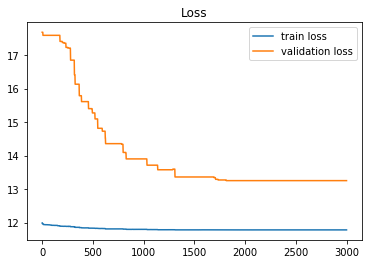

In [160]:
lr = 1e-3
epochs = 3000
batch_size = 120000

model = Model(inputs=input_cols, outputs=[y])
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

model.save_weights(checkpoint_path)

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], global_df['rating'], 
          batch_size=batch_size, epochs=epochs, validation_split=0.005,
                   callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [161]:
# # 모델 불러오기 
# from keras.models import model_from_json 

# json_file = open(os.path.join(model_save_path ," .json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, # custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join(model_save_path," .h5"))
# print("Loaded model from disk")

# 유사도 아이템

In [162]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [163]:
vec = latent_to_vec('FM_locationId', model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
1500428988,10535.094727,10535.549805,10536.004883,10536.459961,10536.915039,10537.370117,10537.825195,10538.280273
1475741466,10284.277344,10284.674805,10285.072266,10285.469727,10285.867188,10286.264648,10286.663086,10287.060547
33880173,-3700.469238,-3700.531250,-3700.593018,-3700.655029,-3700.716797,-3700.778809,-3700.840576,-3700.902344
1517144962,-3795.747314,-3795.809326,-3795.871094,-3795.932861,-3795.994873,-3796.056641,-3796.118652,-3796.180420
1569821908,-3708.883545,-3708.945312,-3709.007324,-3709.069092,-3709.131104,-3709.192871,-3709.254639,-3709.316650
...,...,...,...,...,...,...,...,...
7033805,26421.318359,26421.984375,26422.650391,26423.318359,26423.984375,26424.652344,26425.318359,26425.986328
6643598,21518.197266,21518.865234,21519.531250,21520.199219,21520.865234,21521.533203,21522.199219,21522.867188
8769938,21472.847656,21473.515625,21474.181641,21474.847656,21475.515625,21476.183594,21476.849609,21477.515625


In [164]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_global_vec.csv'))#, index=False)


In [165]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [166]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

데이터 업뎃 후

In [167]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 우드앤브릭
  주소 서울특별시 종로구 재동 5-2
top 2 하겐다즈
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 3 마지
  주소 서울특별시 종로구 체부동 132-1
top 4 육대장
  주소 서울특별시 중구 충무로1가 25-5 고려대연각타워
top 5 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 6 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 7 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 8 언노운커피
  주소 서울특별시 중구 을지로4가 311-7
top 9 일일향
  주소 서울특별시 강남구 신사동 601-3
top 10 화수분베이커리
  주소 서울특별시 중구 신당동 368-104
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 홍대 닭갈비(N)
  주소 서울특별시 마포구 서교동 357-2
top 2 버거뱅
  주소 error
top 3 하동관
  주소 서울특별시 강남구 대치동 891-44 노벨빌딩
top 4 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 5 하코야
  주소 서울특별시 중구 충무로4가 306 남산 센트럴 자이
top 6 언노운커피
  주소 서울특별시 중구 을지로4가 311-7
top 7 일일향
  주소 서울특별시 강남구 신사동 601-3
top 8 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 9 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 10 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
None



--------------------------------------------------
input hotel: 오리엔스호텔&레지던스
----------
top 1 알천생태찌개
  주소 

In [168]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 커피스미스
  주소 서울특별시 강남구 역삼동 819-9 Jerry's planet Building
top 2 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 3 학림
  주소 서울특별시 종로구 명륜4가 94-2
top 4 친친
  주소 서울특별시 마포구 서교동 343-9
top 5 투엘슨 - 카페
  주소 서울특별시 마포구 연남동 568-45
top 6 공차
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
top 7 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 8 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 9 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 10 두레유
  주소 서울특별시 종로구 가회동 16-12
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 태극당
  주소 서울특별시 중구 장충동2가 189-5 태극당
top 2 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 3 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 4 투스카니
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 5 수담 한정식
  주소 서울특별시 강남구 삼성동 113 조양빌딩
top 6 하겐다즈
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 7 돼지집
  주소 서울특별시 중구 태평로2가 69-7 대영빌딩
top 8 임피리얼팰리스 패밀리아
  주소 서울특별시 강남구 논현동 248-7 임피리얼 팰리스호텔
top 9 깡통의 전설
  주소 서울특별시 강남구 대치동 957-20
top 10 진미육가
  주소 서울특별시 동대문구 장안동 433-3
None



-------------------------------

In [169]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 2 나루 가온
  주소 서울특별시 광진구 광장동 102
top 3 스시 효
  주소 서울특별시 강남구 청담동 21-16 유현빌딩
top 4 일치프리아니
  주소 서울특별시 강남구 신사동 651-16 호림아트센터 2빌딩
top 5 삼다연
  주소 error
top 6 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 7 류니끄
  주소 서울특별시 강남구 신사동 520-1
top 8 명동만두
  주소 서울특별시 은평구 불광동 310-11 연서시장
top 9 감나무집기사식당
  주소 서울특별시 마포구 연남동 515-19
top 10 미쓰족발
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 디스틸
  주소 서울특별시 마포구 서교동 410-3 금덩어리
top 2 이태리총각
  주소 서울특별시 종로구 통인동 137-7
top 3 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 4 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 5 샛집남원추어탕
  주소 서울특별시 송파구 방이동 24-1
top 6 수담 한정식
  주소 서울특별시 강남구 삼성동 113 조양빌딩
top 7 타르틴 베이커리 한남점
  주소 서울특별시 용산구 한남동 263-2
top 8 홍대 닭갈비(N)
  주소 서울특별시 마포구 서교동 357-2
top 9 하하
  주소 서울특별시 마포구 연남동 229-12
top 10 무라
  주소 서울특별시 마포구 서교동 401-15
None



--------------------------------------------------
input hotel: 롯데시티호텔 구로
----------
top 

In [170]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 스타즈호텔 명동1호점
----------
top 1 더 스퀘어
  주소 서울특별시 강남구 역삼동 603 노보텔 앰배서더 강남 서울
top 2 마지
  주소 서울특별시 종로구 체부동 132-1
top 3 육대장
  주소 서울특별시 중구 충무로1가 25-5 고려대연각타워
top 4 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 5 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 6 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 7 버거뱅
  주소 error
top 8 카사블랑카 샌드위치
  주소 서울특별시 용산구 용산동2가 44-8
top 9 양미옥
  주소 서울특별시 중구 을지로3가 161
top 10 디스틸
  주소 서울특별시 마포구 서교동 410-3 금덩어리
None



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 퍼블리크
  주소 서울특별시 마포구 상수동 311-1
top 2 송죽
  주소 서울특별시 중구 필동1가 3-1
top 3 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 4 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 5 툇마루밥상
  주소 서울특별시 송파구 문정동 46-11
top 6 철길왕갈비살
  주소 서울특별시 마포구 창전동 4-2
top 7 담뿍담뿍
  주소 서울특별시 중구 을지로6가 18-12 두산타워빌딩
top 8 루소랩
  주소 error
top 9 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 10 닥터 플라토
  주소 서울특별시 송파구 방이동 204
None



--------------------------------------------------
input hotel: 더스테이트 선유 호텔
----------
top 1 무화잠
  주소 서울특별시 강남구 신사

In [171]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 서울뚝배기
  주소 서울특별시 중구 충무로3가 24-14
top 2 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 3 시그니엘 서울 더 라운지
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 4 비사벌전주콩나물국밥
  주소 서울특별시 성동구 성수동1가 661-2
top 5 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 6 오장동 흥남집
  주소 서울특별시 중구 오장동 101-7 흥남집
top 7 유메스시
  주소 서울특별시 강서구 내발산동 646-2
top 8 송림식당
  주소 서울특별시 광진구 자양동 227-136
top 9 아르모니움
  주소 서울특별시 용산구 한남동 657-37
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 2 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 3 로비라운지&델리
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 4 파리바게뜨
  주소 서울특별시 종로구 당주동 100 세종빌딩, 세종아파트
top 5 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 6 라세느
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 7 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 8 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 9 목란
  주소 서울특별시 서대문구 연희동 132-28
top 10 코너스톤, 파크 하얏트 서울
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
None



--------------------------------------------

In [172]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 2 나주곰탕
  주소 서울특별시 관악구 신림동 238-5
top 3 고려삼계탕
  주소 서울특별시 종로구 세종로 164
top 4 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 5 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 6 금해안
  주소 서울특별시 종로구 운니동 96
top 7 쉐즈롤
  주소 서울특별시 마포구 서교동 342-19
top 8 친친
  주소 서울특별시 마포구 서교동 343-9
top 9 최고집
  주소 서울특별시 중구 명동2가 32-2
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 동북화과왕
  주소 서울특별시 종로구 창신동 463-1
top 2 트라토리아 챠오
  주소 서울특별시 마포구 상수동 327-1
top 3 일치프리아니
  주소 서울특별시 강남구 신사동 651-16 호림아트센터 2빌딩
top 4 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 5 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 6 더하기84
  주소 서울특별시 종로구 관훈동 106
top 7 잭슨피자
  주소 서울특별시 용산구 한남동 743-31
top 8 성북동 누룽지백숙
  주소 서울특별시 성북구 성북동 281-1
top 9 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 10 모찌
  주소 서울특별시 용산구 이태원동 126-7
None



--------------------------------------------------
input hotel: 머큐어 서울 앰배서더 강남 쏘도베
----------
top 1

In [173]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 안도
  주소 서울특별시 용산구 한남동 736-8
top 2 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 3 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 4 금해안
  주소 서울특별시 종로구 운니동 96
top 5 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 6 목동쌀보리밥
  주소 서울특별시 종로구 예지동 2-1
top 7 닭한마리
  주소 서울특별시 중구 을지로2가 199-59
top 8 로비라운지&델리
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 9 맘스터치
  주소 서울특별시 용산구 청파동2가 64-15
top 10 브라이리퍼블릭푸드
  주소 서울특별시 용산구 이태원동 63-4
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
top 2 폴바셋
  주소 서울특별시 서초구 잠원동 21-2
top 3 매드후라이치킨
  주소 서울특별시 강남구 도곡동 411-14 유일빌딩
top 4 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 5 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 6 앤트러사이트 커피 로스터
  주소 서울특별시 마포구 합정동 357-6
top 7 페트라
  주소 서울특별시 용산구 이태원동 552
top 8 하모
  주소 서울특별시 강남구 신사동 627-17
top 9 애류헌
  주소 error
top 10 루소랩
  주소 error
None



--------------------------------------------------
input hotel: 오라카이 인사동 스위츠
----------
top 1 감나무집기사식당
  주소 서울특별시 마포구 연남동 

In [174]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 하남돼지집
  주소 서울특별시 마포구 서교동 364-28
top 2 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 3 르스타일
  주소 서울특별시 중구 충무로2가 53-10
top 4 새마을식당 홍대
  주소 서울특별시 마포구 서교동 410-9
top 5 론드리프로젝트
  주소 서울특별시 용산구 용산동2가 15-13
top 6 비밀정원
  주소 서울특별시 종로구 관훈동 8-5 인사유리
top 7 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 8 쉐라톤그랜드워커힐 더뷔페
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 9 던킨 도너츠 사당행복
  주소 서울특별시 서초구 방배동 444-15
top 10 카페코수이
  주소 서울특별시 종로구 통인동 137-1
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 벽제 갈비
  주소 서울특별시 서대문구 창천동 13-20
top 2 서울뚝배기
  주소 서울특별시 중구 충무로3가 24-14
top 3 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 4 바비오네
  주소 서울특별시 서초구 반포동 19-4 강남고속버스터미널
top 5 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 6 Huggers
  주소 error
top 7 오월의종
  주소 서울특별시 용산구 한남동 737-2
top 8 안동찜닭
  주소 error
top 9 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 10 김돈이
  주소 서울특별시 강남구 삼성동 140-29
None



--------------------------------------------------
input hotel: 호텔스카이파크 킹스타운동대문점
----------
top 

In [175]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 타르데마
  주소 서울특별시 강서구 내발산동 702-22
top 2 톡톡
  주소 서울특별시 강남구 신사동 656-6
top 3 쿄베이커리
  주소 서울특별시 마포구 상수동 317-4 상수동 오피스텔
top 4 레드스모크 바비큐
  주소 서울특별시 종로구 관철동 12-23
top 5 삼다연
  주소 error
top 6 탐앤탐스
  주소 서울특별시 송파구 신천동 7-28 현대타워아파트
top 7 우마이도
  주소 서울특별시 광진구 화양동 3-29
top 8 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 9 헴라갓
  주소 서울특별시 중구 회현동1가 208 남산 롯데캐슬
top 10 케냐 키암부 커피
  주소 서울특별시 용산구 이태원동 243-36 케냐대사관
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 도도야
  주소 서울특별시 종로구 동숭동 1-153
top 2 카페 클로리스
  주소 서울특별시 마포구 서교동 358-18 상상사진관
top 3 손가네닭한마리
  주소 서울특별시 종로구 숭인동 201-13 평화빌딩
top 4 스시 효
  주소 서울특별시 강남구 청담동 21-16 유현빌딩
top 5 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 6 이성당카페
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 7 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 8 88브레드
  주소 서울특별시 강남구 신사동 566-3
top 9 라운드오프
  주소 서울특별시 종로구 관훈동 198-1 홍익빌딩
top 10 연탄불꼼장어
  주소 서울특별시 성동구 성수동1가 656-287
None



--------------------------------------------------
input hotel: 라까사호텔 

In [176]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 2 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 3 Myeongdong Gyoja Cheongdaemun
  주소 error
top 4 신의주부대찌개
  주소 서울특별시 중구 북창동 14-5
top 5 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 6 수와래
  주소 서울특별시 종로구 삼청동 35-116
top 7 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
top 8 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 9 줄라이
  주소 서울특별시 서초구 반포동 577-20 줄라이빌딩
top 10 도사 바이 백승욱
  주소 서울특별시 강남구 청담동 92-12 파크빌딩
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 토다이
  주소 서울특별시 강남구 대치동 1005-5
top 2 대장금
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 3 피그인더가든
  주소 서울특별시 영등포구 여의도동 23-5 한화손해보험빌딩
top 4 브리오슈도레그랑서울점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 5 베제투스
  주소 서울특별시 용산구 용산동2가 22-12
top 6 빌리엔젤케익컴퍼니
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 7 카페 뎀셀브즈
  주소 서울특별시 종로구 관철동 5-8
top 8 동원집
  주소 error
top 9 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 10 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
None



-----------------------------

In [177]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 라구뜨
  주소 서울특별시 광진구 자양동 227-342 롯데백화점
top 2 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 3 헴라갓
  주소 서울특별시 중구 회현동1가 208 남산 롯데캐슬
top 4 케냐 키암부 커피
  주소 서울특별시 용산구 이태원동 243-36 케냐대사관
top 5 내림손 삼계탕
  주소 서울특별시 중구 명동1가 10-1 명동센트럴빌딩
top 6 더 파크뷰
  주소 error
top 7 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 8 구스테이크 733
  주소 서울특별시 용산구 한남동 733-70
top 9 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 10 322소월로-카우리
  주소 서울특별시 용산구 한남동 747-7 하얏트호텔
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 인사동 수제비
  주소 서울특별시 종로구 관훈동 29-2
top 2 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 3 배드파머스
  주소 서울특별시 강남구 신사동 523-21
top 4 연죽
  주소 서울특별시 종로구 익선동 137-2
top 5 차우기
  주소 서울특별시 종로구 운니동 45-3 453 STairs
top 6 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 7 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 8 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
top 9 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 10 도도야
  주소 서울특별시 종로구 동숭동 1-153
None



--------------------------------------------------
input hotel: 더 그랜드 

In [178]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 유메스시
  주소 서울특별시 강서구 내발산동 646-2
top 2 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 3 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 4 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
top 5 스티키리키 아이스크림
  주소 서울특별시 용산구 갈월동 53-8
top 6 잭슨피자
  주소 서울특별시 용산구 한남동 743-31
top 7 호밀밭
  주소 서울특별시 서대문구 창천동 4-77
top 8 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 9 원대구탕
  주소 서울특별시 용산구 한강로1가 142-4
top 10 라운드오프
  주소 서울특별시 종로구 관훈동 198-1 홍익빌딩
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 마포만두
  주소 서울특별시 중구 충무로3가 25-18
top 2 혜성칼국수
  주소 서울특별시 동대문구 청량리동 50-18
top 3 백운봉막국수 역삼동점
  주소 서울특별시 강남구 역삼동 672-37 역삼빌딩
top 4 아르모니움
  주소 서울특별시 용산구 한남동 657-37
top 5 목란
  주소 서울특별시 종로구 평동 26-10
top 6 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 7 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 8 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 9 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 10 을밀대 평양냉면
  주소 서울특별시 마포구 염리동 147-6
None



--------------------------------------------------
input hotel: 까사 명동 게스트하우스

In [179]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 페스타 바이 민구
  주소 서울특별시 중구 쌍림동 88-9
top 2 호수집
  주소 서울특별시 중구 중림동 61-4
top 3 안동국시
  주소 서울특별시 마포구 공덕동 105-137
top 4 세종참치
  주소 서울특별시 중구 충무로2가 61-3 세종서적
top 5 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 6 뜨리앙
  주소 서울특별시 강남구 청담동 81-7
top 7 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 8 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 9 돈수백
  주소 서울특별시 마포구 동교동 164-24
top 10 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 2 테이블15
  주소 서울특별시 마포구 서교동 394-14
top 3 랩24
  주소 서울특별시 강남구 신사동 643-1
top 4 퍼블리크
  주소 서울특별시 마포구 상수동 311-1
top 5 송림식당
  주소 서울특별시 광진구 자양동 227-136
top 6 희죽희죽
  주소 서울특별시 중구 충무로2가 61-2
top 7 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 8 이요이요스시
  주소 서울특별시 마포구 아현동 772
top 9 그랑 아
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 10 마포만두
  주소 서울특별시 중구 충무로3가 25-18
None



--------------------------------------------------
input hotel: 시어소 호텔
----------
top 1 맛찬들왕소금구이
  

In [180]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 2 혜성칼국수
  주소 서울특별시 동대문구 청량리동 50-18
top 3 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 4 커피한약방
  주소 서울특별시 중구 을지로2가 101-34
top 5 아오이토리
  주소 서울특별시 마포구 서교동 327-17 K.C빌딩
top 6 남산골 산채집
  주소 서울특별시 중구 예장동 8-16
top 7 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 8 감나무집기사식당
  주소 서울특별시 마포구 연남동 515-19
top 9 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 10 라따블
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 타이거타이거
  주소 서울특별시 종로구 권농동 171-6
top 2 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
top 3 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 4 부촌육회
  주소 서울특별시 종로구 종로4가 165-11
top 5 루트
  주소 서울특별시 용산구 한남동 741-19
top 6 동북화과왕
  주소 서울특별시 종로구 창신동 463-1
top 7 애류헌
  주소 error
top 8 뿌자
  주소 서울특별시 종로구 창신동 207
top 9 닭한마리
  주소 서울특별시 중구 을지로2가 199-59
top 10 항아리수제비
  주소 서울특별시 성동구 성수동1가 656-1037
None



--------------------------------------------------
input hotel: 라마다 서울 동대문
----------
top 1 피에르바
  주소

In [181]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 2 수와래
  주소 서울특별시 종로구 삼청동 35-116
top 3 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 4 명동 피자
  주소 서울특별시 중구 충무로1가 22-2
top 5 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 6 매니멀스모크하우스
  주소 서울특별시 용산구 이태원동 455-33
top 7 삼통치킨
  주소 서울특별시 종로구 인사동 72
top 8 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 모찌
  주소 서울특별시 용산구 이태원동 126-7
top 10 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 보칼리노
  주소 error
top 2 친친
  주소 서울특별시 마포구 서교동 343-9
top 3 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 4 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 5 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 6 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 7 금해안
  주소 서울특별시 종로구 운니동 96
top 8 종로설렁탕
  주소 서울특별시 종로구 창신동 444-9 임진빌딩
top 9 커피바K
  주소 서울특별시 강남구 청담동 89-20
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 뉴국제호텔
----------
top 1 무차초 서울
  주소 서울특별시 강남구 역삼동 812-18
top 2 대도식당 왕십리

In [182]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 2 VIPS
  주소 서울특별시 종로구 혜화동 90-18 혜화동씨티밸리
top 3 송죽
  주소 서울특별시 중구 필동1가 3-1
top 4 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 5 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 6 줄라이
  주소 서울특별시 서초구 반포동 577-20 줄라이빌딩
top 7 육회자매집 본점1호점
  주소 서울특별시 종로구 종로4가 177 제우빌딩
top 8 무차초 서울
  주소 서울특별시 강남구 역삼동 812-18
top 9 호수집
  주소 서울특별시 중구 중림동 61-4
top 10 쿄베이커리
  주소 서울특별시 마포구 상수동 317-4 상수동 오피스텔
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 툭툭누들타이
  주소 서울특별시 서대문구 연희동 353-89
top 2 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 3 베나레스 본점
  주소 서울특별시 성북구 안암동5가 102-59
top 4 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 5 뿌자
  주소 서울특별시 종로구 창신동 207
top 6 빈스빈스
  주소 서울특별시 서대문구 대현동 56-126
top 7 금해안
  주소 서울특별시 종로구 운니동 96
top 8 그안
  주소 서울특별시 중구 장충동2가 190-10 디자인하우스
top 9 Momoyama
  주소 error
top 10 어니언
  주소 서울특별시 성동구 성수동2가 277-135
None



--------------------------------------------------
input hotel: 호텔 봉봉
----------
top 1 현초밥
  주소 서울특별시 종로

In [183]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴 오리엔탈 호텔
----------
top 1 송죽
  주소 서울특별시 중구 필동1가 3-1
top 2 줄라이
  주소 서울특별시 서초구 반포동 577-20 줄라이빌딩
top 3 토마틸로
  주소 서울특별시 강남구 역삼동 737 강남파이낸스센터
top 4 아따블르
  주소 서울특별시 종로구 팔판동 104-8
top 5 오장동 흥남집
  주소 서울특별시 중구 오장동 101-7 흥남집
top 6 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 7 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 8 던킨 도너츠 서울역1호
  주소 error
top 9 부자피자 1호점
  주소 서울특별시 용산구 한남동 743-33
top 10 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
None



--------------------------------------------------
input hotel: 토모 레지던스
----------
top 1 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 2 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 3 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 4 보칼리노
  주소 error
top 5 홍연
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 6 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
top 7 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 8 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 9 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 10 호박식당
  주소 서울특별시 용산구 한남동 657-85
None



--------------------------------------------------
input hotel: 에이큐브 호텔
----------
top 1 한우리 한정식
  주소 서울특별시 강남구 

In [184]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 우촌 돌솥 설렁탕
  주소 서울특별시 중구 저동2가 10
top 2 종로설렁탕
  주소 서울특별시 종로구 창신동 444-9 임진빌딩
top 3 대박집
  주소 error
top 4 호수집
  주소 서울특별시 중구 중림동 61-4
top 5 조박집
  주소 서울특별시 마포구 용강동 40-1
top 6 서울서 둘째로 잘하는 집
  주소 서울특별시 종로구 삼청동 28-21
top 7 조개와
  주소 서울특별시 중구 을지로2가 200
top 8 곤트란쉐리에
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 9 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 10 인사동 수제비
  주소 서울특별시 종로구 관훈동 29-2
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 2 한우리 한정식
  주소 서울특별시 강남구 논현동 91-4 코오라빌딩
top 3 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 4 도도야
  주소 서울특별시 종로구 동숭동 1-153
top 5 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 6 보칼리노
  주소 error
top 7 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 8 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
top 9 두레유
  주소 서울특별시 종로구 가회동 16-12
top 10 다이닝인스페이스
  주소 서울특별시 종로구 원서동 219
None



--------------------------------------------------
input hotel: 이비스 앰배서더 서울 명동
----------
top 1 맛찬들왕소금구이

In [185]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 커피바K
  주소 서울특별시 강남구 청담동 89-20
top 2 조박집
  주소 서울특별시 마포구 용강동 40-1
top 3 일미간장게장
  주소 서울특별시 동대문구 장안동 367-3
top 4 보칼리노
  주소 error
top 5 와플반트
  주소 서울특별시 서초구 반포동 865 구반포상가
top 6 잭슨피자
  주소 서울특별시 용산구 한남동 743-31
top 7 송죽
  주소 서울특별시 중구 필동1가 3-1
top 8 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 9 황토골
  주소 서울특별시 중구 충무로5가 79-1 인산빌딩
top 10 톡톡
  주소 서울특별시 강남구 신사동 656-6
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 2 이태리총각
  주소 서울특별시 종로구 통인동 137-7
top 3 405키친
  주소 서울특별시 강남구 역삼동 617-4
top 4 세븐스퀘어
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 5 진미육가
  주소 서울특별시 동대문구 장안동 433-3
top 6 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 7 먹거리집
  주소 서울특별시 성동구 성수동1가 656-1076
top 8 르스타일
  주소 서울특별시 중구 충무로2가 53-10
top 9 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 10 하하
  주소 서울특별시 마포구 연남동 229-12
None



--------------------------------------------------
input hotel: 프레이저 플레이스 센트럴 서울
----------
top 1 옥토버훼스트 종로점
  주소 서울특별시 

In [186]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 브레라
  주소 서울특별시 중구 신당동 366-440
top 2 디스틸
  주소 서울특별시 마포구 서교동 410-3 금덩어리
top 3 무라
  주소 서울특별시 마포구 서교동 401-15
top 4 스즈란테이
  주소 서울특별시 용산구 이촌동 301-10 로얄상가
top 5 투스카니
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 6 양미옥
  주소 서울특별시 중구 을지로3가 161
top 7 카사블랑카 샌드위치
  주소 서울특별시 용산구 용산동2가 44-8
top 8 버거뱅
  주소 error
top 9 르스타일
  주소 서울특별시 중구 충무로2가 53-10
top 10 화수분베이커리
  주소 서울특별시 중구 신당동 368-104
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 조선호텔베이커리
  주소 서울특별시 중구 회현동1가 204 MESA
top 2 탐앤탐스
  주소 서울특별시 송파구 신천동 7-28 현대타워아파트
top 3 단풍나무집
  주소 서울특별시 종로구 삼청동 31-1
top 4 갓덴스시
  주소 서울특별시 종로구 관철동 19-1 해덕빌딩
top 5 레이지쿠오레
  주소 서울특별시 강남구 신사동 650-8
top 6 Seongbukdongjip
  주소 error
top 7 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 8 김북순 큰남비집
  주소 서울특별시 강남구 신사동 536-8 우림빌딩
top 9 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 10 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
None



--------------------------------------------------
input hotel: 메이 플레이스 서울 동대문
----------
top 

In [187]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 김가네김밥
  주소 서울특별시 중구 충무로1가 25-45
top 2 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 3 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 4 페트라
  주소 서울특별시 용산구 이태원동 552
top 5 혼가츠
  주소 서울특별시 마포구 서교동 358-49
top 6 단스시
  주소 서울특별시 강남구 논현동 238 쿠쿠빌딩
top 7 소담채
  주소 서울특별시 서초구 원지동 419-1
top 8 강서면옥 압구정점
  주소 서울특별시 강남구 신사동 645-30
top 9 백운봉막국수 역삼동점
  주소 서울특별시 강남구 역삼동 672-37 역삼빌딩
top 10 타르데마
  주소 서울특별시 강서구 내발산동 702-22
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 2046 팬 스테이크
  주소 서울특별시 종로구 계동 102-1 연화빌딩
top 2 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 3 버드나무집
  주소 서울특별시 서초구 서초2동 1340-5 버드나무집
top 4 김밥나라
  주소 서울특별시 종로구 종로6가 83
top 5 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 6 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 7 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 8 양국
  주소 서울특별시 강남구 역삼동 643-3
top 9 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 10 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
None



--------------------------------------------------
input hotel: 선샤인

In [188]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 로비라운지&델리
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 2 올드페리도넛
  주소 서울특별시 용산구 한남동 727-21
top 3 Myeongdong Gyoja Cheongdaemun
  주소 error
top 4 혜성칼국수
  주소 서울특별시 동대문구 청량리동 50-18
top 5 나루 가온
  주소 서울특별시 광진구 광장동 102
top 6 민가다헌
  주소 서울특별시 종로구 경운동 66-7
top 7 모찌
  주소 서울특별시 용산구 이태원동 126-7
top 8 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 밍1956
  주소 서울특별시 중구 소공동 24 대호
top 10 닥터 플라토
  주소 서울특별시 송파구 방이동 204
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 예 신라삼계탕
  주소 서울특별시 중구 순화동 151 순화동더샵
top 2 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 3 더 플라잉 팬 블루
  주소 서울특별시 용산구 이태원동 123-7
top 4 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 5 와플반트
  주소 서울특별시 서초구 반포동 865 구반포상가
top 6 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 7 The View
  주소 error
top 8 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 9 온더보더
  주소 서울특별시 영등포구 여의도동 23 서울 국제금융 센터
top 10 해우리
  주소 서울특별시 영등포구 여의도동 23 서울 국제금융 센터
None



--------------------------------------------------
input hotel: 

In [189]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 2 일야에스프레소
  주소 서울특별시 마포구 염리동 172-1 일야빌딩
top 3 목포집
  주소 서울특별시 강남구 신사동 512-18
top 4 황생가칼국수
  주소 서울특별시 종로구 소격동 84
top 5 현초밥
  주소 서울특별시 종로구 명륜4가 166-1 영성빌딩
top 6 어니언 안국
  주소 서울특별시 종로구 계동 146-1
top 7 할랄키친
  주소 서울특별시 종로구 삼청동 63-17
top 8 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
top 9 Kervan Bakery
  주소 서울특별시 용산구 이태원동 126-2
top 10 마노디셰프
  주소 서울특별시 강남구 삼성동 158-24 동성빌딩
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 장수갈매기
  주소 서울특별시 마포구 도화동 182-11
top 2 안동찜닭
  주소 error
top 3 리치몬드제과점
  주소 서울특별시 마포구 성산동 114-5 리치몬드빌딩
top 4 내림손 삼계탕
  주소 서울특별시 중구 명동1가 10-1 명동센트럴빌딩
top 5 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 6 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 7 존시카고피자앤펍
  주소 서울특별시 용산구 이태원동 118-3
top 8 Kervan Bakery
  주소 서울특별시 용산구 이태원동 126-2
top 9 빈스빈스
  주소 서울특별시 마포구 공덕동 461 마포신영지웰
top 10 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
None



--------------------------------------------------


In [190]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 2 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 3 서래갈매기
  주소 서울특별시 중구 필동3가 12-1
top 4 경성갈비
  주소 서울특별시 강남구 대치동 996-7
top 5 좋은세상만들기
  주소 서울특별시 영등포구 양평동4가 281 르네상스 한강 오피스텔
top 6 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 7 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 8 고려삼계탕
  주소 서울특별시 중구 서소문동 55-3
top 9 투뿔등심
  주소 서울특별시 중구 태평로1가 84 파이낸스빌딩
top 10 연탄불꼼장어
  주소 서울특별시 성동구 성수동1가 656-287
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
top 2 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 3 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 4 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 5 맥애덤스 커피
  주소 서울특별시 종로구 운니동 43
top 6 금해안
  주소 서울특별시 종로구 운니동 96
top 7 친친
  주소 서울특별시 마포구 서교동 343-9
top 8 투엘슨 - 카페
  주소 서울특별시 마포구 연남동 568-45
top 9 고려삼계탕
  주소 서울특별시 종로구 세종로 164
top 10 공차
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
None



--------------------------------------------------
input hotel: 몽호텔
----------
to